In [79]:
import os
import time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import folium
from folium.plugins import HeatMap
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from scipy.stats import chisquare
from sklearn.neighbors import LocalOutlierFactor
from scipy.spatial.distance import cdist
import requests
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString
from shapely.ops import linemerge
from shapely.geometry import Point
from shapely import wkt


from neo4j import GraphDatabase


plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)

In [80]:
REMOTE_BASE_PATH='/tmp/pycharm_project_992'

file = "/tmp/pycharm_project_992/data/datasets/raw/Censo vertidos.xlsx"

df = pd.read_excel(file, header=4)

print("Primeras 5 filas:")
df.head()

print("\nInformación del DataFrame:")
df.info()

Primeras 5 filas:

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1837 entries, 0 to 1836
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              0 non-null      float64
 1   NOMBRE DEL VERTIDO      1836 non-null   object 
 2   TITULAR                 1835 non-null   object 
 3   MUNICIPIO DEL VERTIDO   1835 non-null   object 
 4   PROVINCIA VERTIDO       1835 non-null   object 
 5   UTM X 
Huso 30          1835 non-null   float64
 6   UTM Y 
Huso 30          1835 non-null   float64
 7   MEDIO     RECEPTOR      1835 non-null   object 
 8   NATURALEZA DEL VERTIDO  1835 non-null   object 
 9   CARACT. DEL VERTIDO     1835 non-null   object 
 10  VOLUMEN (m3/año)        1835 non-null   float64
 11  NATURALEZA M.RECEPTOR   1835 non-null   object 
 12  REF. EXPED.             1835 non-null   object 
dtypes: float64(4), object(9)
memory usage: 186.7+ K

# Limpieza

In [81]:
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

Limpiar y renombrar columnas para que sean más fáciles de usar (Quitar \n, espacios y paréntesis)

In [82]:
df.columns = df.columns.str.replace(r'\s+', ' ', regex=True).str.strip()

# Ahora ejecuta tu rename de nuevo
df = df.rename(columns={
    'NOMBRE DEL VERTIDO': 'NOMBRE_VERTIDO',
    'MUNICIPIO DEL VERTIDO': 'MUNICIPIO',
    'PROVINCIA VERTIDO': 'PROVINCIA',
    'UTM X Huso 30': 'UTM_X',
    'UTM Y Huso 30': 'UTM_Y',
    'MEDIO RECEPTOR': 'MEDIO_RECEPTOR',
    'NATURALEZA DEL VERTIDO': 'NATURALEZA_VERTIDO',
    'CARACT. DEL VERTIDO': 'CARACT_VERTIDO',
    'VOLUMEN (m3/año)': 'VOLUMEN_m3_ano',
    'NATURALEZA M.RECEPTOR': 'NATURALEZA_RECEPTOR',
    'REF. EXPED.': 'REF_EXPEDIENTE'
})

In [83]:
df.head()

,NOMBRE_VERTIDO,TITULAR,MUNICIPIO,PROVINCIA,UTM_X,UTM_Y,MEDIO_RECEPTOR,NATURALEZA_VERTIDO,CARACT_VERTIDO,VOLUMEN_m3_ano,NATURALEZA_RECEPTOR,REF_EXPEDIENTE
0,DROMEN GESTORES Y CONSULTORES (VIV. UNIFAMILIAR),"DROMEN GESTORES Y CONSULTORES, S.L.",ADRADA (LA),AVILA,358144.0,4460601.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,231.0,CATEGORÍA I,AV-0006/2020
1,PIZZERIA-RESTAURANTE PUENTE MOCHA,PERSONA FÍSICA,ADRADA (LA),AVILA,358290.0,4459633.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,1188.0,CATEGORÍA I,AV-0049/1999
2,CENTRO HÍPICO LA ESPUELA,"CORPORACIÓN RILUMI, S.L.",ADRADA (LA),AVILA,358288.0,4459174.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,3650.0,CATEGORÍA I,AV-0041/2015
3,EDAR LA ADRADA,AYUNTAMIENTO DE LA ADRADA,ADRADA (LA),AVILA,359461.0,4460939.0,ARROYO FRANQUILLO,URBANO O ASIMILABLE,2.000-10.000 h-e,1193058.0,CATEGORÍA I,AV-0053/2014
4,PERSONA FÍSICA (VIVIENDAS),PERSONA FÍSICA,ADRADA (LA),AVILA,357353.0,4461118.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,102.0,CATEGORÍA I,AV-0041/2017


Eliminar las filas que tienen valores nulos en columnas clave (ej. TITULAR o MUNICIPIO) Esto eliminará 2 filas que parecían vacías

In [84]:
df = df.dropna(subset=['TITULAR', 'MUNICIPIO', 'VOLUMEN_m3_ano'])

In [85]:
print("Datos limpios:")
df.head()

Datos limpios:


,NOMBRE_VERTIDO,TITULAR,MUNICIPIO,PROVINCIA,UTM_X,UTM_Y,MEDIO_RECEPTOR,NATURALEZA_VERTIDO,CARACT_VERTIDO,VOLUMEN_m3_ano,NATURALEZA_RECEPTOR,REF_EXPEDIENTE
0,DROMEN GESTORES Y CONSULTORES (VIV. UNIFAMILIAR),"DROMEN GESTORES Y CONSULTORES, S.L.",ADRADA (LA),AVILA,358144.0,4460601.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,231.0,CATEGORÍA I,AV-0006/2020
1,PIZZERIA-RESTAURANTE PUENTE MOCHA,PERSONA FÍSICA,ADRADA (LA),AVILA,358290.0,4459633.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,1188.0,CATEGORÍA I,AV-0049/1999
2,CENTRO HÍPICO LA ESPUELA,"CORPORACIÓN RILUMI, S.L.",ADRADA (LA),AVILA,358288.0,4459174.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,3650.0,CATEGORÍA I,AV-0041/2015
3,EDAR LA ADRADA,AYUNTAMIENTO DE LA ADRADA,ADRADA (LA),AVILA,359461.0,4460939.0,ARROYO FRANQUILLO,URBANO O ASIMILABLE,2.000-10.000 h-e,1193058.0,CATEGORÍA I,AV-0053/2014
4,PERSONA FÍSICA (VIVIENDAS),PERSONA FÍSICA,ADRADA (LA),AVILA,357353.0,4461118.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,102.0,CATEGORÍA I,AV-0041/2017


In [86]:
print("\nNueva información del DataFrame:")
df.info()


Nueva información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 1835 entries, 0 to 1834
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   NOMBRE_VERTIDO       1835 non-null   object 
 1   TITULAR              1835 non-null   object 
 2   MUNICIPIO            1835 non-null   object 
 3   PROVINCIA            1835 non-null   object 
 4   UTM_X                1835 non-null   float64
 5   UTM_Y                1835 non-null   float64
 6   MEDIO_RECEPTOR       1835 non-null   object 
 7   NATURALEZA_VERTIDO   1835 non-null   object 
 8   CARACT_VERTIDO       1835 non-null   object 
 9   VOLUMEN_m3_ano       1835 non-null   float64
 10  NATURALEZA_RECEPTOR  1835 non-null   object 
 11  REF_EXPEDIENTE       1835 non-null   object 
dtypes: float64(3), object(9)
memory usage: 186.4+ KB


Clasificar los titulares

In [87]:
def clasificar_titular(titular):
    """
    Clasifica el titular basándose en ciertas palabras clave.
    Retorna: 'A', 'F', 'J', o np.nan si no se clasifica.
    """
    if pd.isna(titular):
        return np.nan # Manejar valores nulos si existen

    # Convertir a mayúsculas para asegurar una búsqueda sin distinción
    titular_upper = str(titular).upper()

    # Clasificación 'A' - AYUNTAMIENTO
    terminos_admin = ['AYUNTAMIENTO', 'MINISTERIO', 'JUNTA', 'ACUARTELAMIENTO']
    if any(term in titular_upper for term in terminos_admin):
        return 'A'

    # Clasificación 'F' - PERSONA FÍSICA
    # Buscamos 'PERSONA FÍSICA' o sinónimos comunes de 'particular'
    if 'PERSONA FÍSICA' in titular_upper or 'PARTICULAR' in titular_upper:
        return 'F'

    # Clasificación 'J' - PERSONAS JURÍDICAS (Sociedades)
    # Lista de términos comunes para personas jurídicas
    terminos_juridicos = ['S.L.', 'SL.', 'S.L', 'S. A.', 'SA.', 'S.A', 'SOCIEDAD', 'CORPORACION', 'FUNDACIÓN', 'SLU', 'SAU', 'SRL', 'COMUNIDAD', 'COM', 'ASOCIACIÓN', 'PARROQUIA']

    # Verificamos si alguno de los términos jurídicos está en el titular
    if any(term in titular_upper for term in terminos_juridicos):
        return 'J'

    # Si no coincide con ninguna de las categorías anteriores
    return np.nan # Usamos np.nan (Not a Number) para indicar no clasificado

In [88]:
df['tipo_titular'] = df['TITULAR'].apply(clasificar_titular)

In [89]:
df[df['tipo_titular'].isnull()]

,NOMBRE_VERTIDO,TITULAR,MUNICIPIO,PROVINCIA,UTM_X,UTM_Y,MEDIO_RECEPTOR,NATURALEZA_VERTIDO,CARACT_VERTIDO,VOLUMEN_m3_ano,NATURALEZA_RECEPTOR,REF_EXPEDIENTE,tipo_titular
13,RESTAURANTE GRUTAS DEL AGUILA,"HERMANOS MUÑOZ PEREDA, C.B.",ARENAS DE SAN PEDRO,AVILA,323675.0,4447222.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,2600.0,CATEGORÍA I,AV-0050/1999,NaN
33,EATON PLANNING LIMITED (VIV. UNIFAMILIAR),EATON PLANNING LIMITED,ARENAS DE SAN PEDRO,AVILA,317131.0,4441014.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,438.0,CATEGORÍA I,AV-0111/2011,NaN
59,CAMPAMENTO SANTA MARÍA DEL MONTE,CONGREGACIÓN LEGIONARIOS DE CRISTO,BURGOHONDO,AVILA,348368.0,4473405.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,730.0,CATEGORÍA I,AV-0020/2019,NaN
119,HOSTELERÍA EL CORRALÓN,GREDOS SAN DIEGO S. COOP. MAD.,CASAVIEJA,AVILA,348843.0,4462227.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,6000.0,CATEGORÍA I,AV-0072/2021,NaN
178,COLONIA INFANTIL VENERO CLARO,CAJA DE AHORROS Y M. DE P. DE AVILA,NAVALUENGA,AVILA,358772.0,4474592.0,GARGANTA CABRERA,URBANO O ASIMILABLE,<2.000 h-e,2000.0,CATEGORÍA I,AV-0027/1994,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819,URB. VEGA DEL CASTILLO,E.U.C.C. VEGA DEL CASTILLO,VISO DE SAN JUAN (EL),TOLEDO,415310.0,4443982.0,RÍO GUADARRAMA,URBANO O ASIMILABLE,<2.000 h-e,7300.0,CATEGORÍA I,AV-0050/2009,NaN
1820,URB. LAS ZANJAS,E.U.C.C. LAS ZANJAS,VISO DE SAN JUAN (EL),TOLEDO,419571.0,4444971.0,AFLUENTE DEL ARROYO VALSECO,URBANO O ASIMILABLE,<2.000 h-e,11680.0,CATEGORÍA I,AV-0104/2008,NaN
1822,URB. CAMINO DE LOS FRAILES,E.U.C.C. CAMINO DE LOS FRAILES,VISO DE SAN JUAN (EL),TOLEDO,414490.0,4444673.0,ARROYO PRADO DE LOS CABALLOS,URBANO O ASIMILABLE,<2.000 h-e,16425.0,CATEGORÍA I,AV-0090/2001,NaN
1823,URB. SAN MARCOS,E.U.C.C. URB. SAN MARCOS,VISO DE SAN JUAN (EL),TOLEDO,415794.0,4444407.0,RÍO GUADARRAMA,URBANO O ASIMILABLE,<2.000 h-e,34310.0,CATEGORÍA I,AV-0605/1987,NaN


In [90]:
df.head()

,NOMBRE_VERTIDO,TITULAR,MUNICIPIO,PROVINCIA,UTM_X,UTM_Y,MEDIO_RECEPTOR,NATURALEZA_VERTIDO,CARACT_VERTIDO,VOLUMEN_m3_ano,NATURALEZA_RECEPTOR,REF_EXPEDIENTE,tipo_titular
0,DROMEN GESTORES Y CONSULTORES (VIV. UNIFAMILIAR),"DROMEN GESTORES Y CONSULTORES, S.L.",ADRADA (LA),AVILA,358144.0,4460601.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,231.0,CATEGORÍA I,AV-0006/2020,J
1,PIZZERIA-RESTAURANTE PUENTE MOCHA,PERSONA FÍSICA,ADRADA (LA),AVILA,358290.0,4459633.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,1188.0,CATEGORÍA I,AV-0049/1999,F
2,CENTRO HÍPICO LA ESPUELA,"CORPORACIÓN RILUMI, S.L.",ADRADA (LA),AVILA,358288.0,4459174.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,3650.0,CATEGORÍA I,AV-0041/2015,J
3,EDAR LA ADRADA,AYUNTAMIENTO DE LA ADRADA,ADRADA (LA),AVILA,359461.0,4460939.0,ARROYO FRANQUILLO,URBANO O ASIMILABLE,2.000-10.000 h-e,1193058.0,CATEGORÍA I,AV-0053/2014,A
4,PERSONA FÍSICA (VIVIENDAS),PERSONA FÍSICA,ADRADA (LA),AVILA,357353.0,4461118.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,102.0,CATEGORÍA I,AV-0041/2017,F


# Visualización inicial del Dataframe

In [91]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1835 entries, 0 to 1834
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   NOMBRE_VERTIDO       1835 non-null   object 
 1   TITULAR              1835 non-null   object 
 2   MUNICIPIO            1835 non-null   object 
 3   PROVINCIA            1835 non-null   object 
 4   UTM_X                1835 non-null   float64
 5   UTM_Y                1835 non-null   float64
 6   MEDIO_RECEPTOR       1835 non-null   object 
 7   NATURALEZA_VERTIDO   1835 non-null   object 
 8   CARACT_VERTIDO       1835 non-null   object 
 9   VOLUMEN_m3_ano       1835 non-null   float64
 10  NATURALEZA_RECEPTOR  1835 non-null   object 
 11  REF_EXPEDIENTE       1835 non-null   object 
 12  tipo_titular         1490 non-null   object 
dtypes: float64(3), object(10)
memory usage: 200.7+ KB
None


Vamos a mirar primero el asunto de los titulares nulos, es la única columna nula que tenemos

In [92]:
df[df['tipo_titular'].isna()].groupby('TITULAR').count().sort_values(by='NOMBRE_VERTIDO', ascending=False)

,NOMBRE_VERTIDO,MUNICIPIO,PROVINCIA,UTM_X,UTM_Y,MEDIO_RECEPTOR,NATURALEZA_VERTIDO,CARACT_VERTIDO,VOLUMEN_m3_ano,NATURALEZA_RECEPTOR,REF_EXPEDIENTE,tipo_titular
TITULAR,,,,,,,,,,,,
CANAL DE ISABEL II,166,166,166,166,166,166,166,166,166,166,166,0
CONSORCIO DE SS. PP. MEDIOAMBIENTALES DE TOLEDO,7,7,7,7,7,7,7,7,7,7,7,0
"CENTRAL NUCLEAR DE TRILLO I, C.B.",4,4,4,4,4,4,4,4,4,4,4,0
C.B. CENTRAL NUCLEAR DE ALMARAZ,3,3,3,3,3,3,3,3,3,3,3,0
ADMINISTRADOR DE INFRAESTRUCTURAS FERROVIARIAS (ADIF),3,3,3,3,3,3,3,3,3,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
UNIVERSIDAD AUTONOMA DE MADRID,1,1,1,1,1,1,1,1,1,1,1,0
"UNIÓN DE AGRICULTORES DE RIOLOBOS, S.C.L.",1,1,1,1,1,1,1,1,1,1,1,0
UNIÓN DE IGLESIAS ADVENTISTAS DEL SÉPTIMO DÍA (UICASDE),1,1,1,1,1,1,1,1,1,1,1,0


Vemos rápidamente que podemos imputar una gran cantidad de ellos al Canal de Isabel II. Ahora preparamos la función v2 para cazar nulos a medida

In [93]:
def clasificar_titular_v2(titular):
    """
    Clasifica el titular basándose en ciertas palabras clave.
    Retorna: 'A', 'F', 'J', o np.nan si no se clasifica.
    """
    if pd.isna(titular):
        return np.nan # Manejar valores nulos si existen

    # Convertir a mayúsculas para asegurar una búsqueda sin distinción
    titular_upper = str(titular).upper()

    # Clasificación 'A' - ADMIN PÚBLICA
    terminos_admin = [
        # Entidades Locales
        'AYUNTAMIENTO', 'DIPUTACIÓN', 'JUNTA', 'CONSEJERÍA', 'MANCOMUNIDAD',
        'CONSORCIO', 'CABILDO', 'CONSELL', 'E.A.T.I.M.', 'EATIM', 'ENTIDAD LOCAL',
        'ADM. LOCAL' ,'SAECO',
        # Administración General y Organismos Públicos
        'MINISTERIO', 'Mº ', 'GOBIERNO', 'CONFEDERACIÓN', 'AGENCIA', 'INSTITUTO', 'INST.',
        'ADIF', 'RENFE', 'PUERTOS DEL ESTADO', 'CH ', 'C.H.',
        'CEDEX', 'I.N.T.A.', ' INTA ', 'PENITENCIARIO', 'CONSEJERIA','PARQUES NACIONALES',
        'DIPUTACION',# Organismos técnicos específicos
        # Defensa
        'DEFENSA', 'EJÉRCITO', 'ARMADA', 'GUARDIA CIVIL', 'POLICÍA',
        'ACUARTELAMIENTO', 'CUARTEL', 'BASE ', 'ACADEMIA DE', 'BRIAC','SERVICIO DE SALUD',
        # Instrumental
        'CANAL DE ISABEL', 'INFRAESTRUCTURAS DEL AGUA', 'UNIVERSIDAD', 'HOSPITAL', 'COLEGIO'
    ]

    if any(term in titular_upper for term in terminos_admin):
        return 'A'

    # Clasificación 'F' - PERSONA FÍSICA
    # Buscamos 'PERSONA FÍSICA' o sinónimos comunes de 'particular'
    if 'PERSONA FÍSICA' in titular_upper or 'PARTICULAR' in titular_upper:
        return 'F'

    # Clasificación 'J' - PERSONAS JURÍDICAS (Sociedades)
    # Lista de términos comunes para personas jurídicas
    terminos_juridicos = [
        # Sociedades Mercantiles y Financieras
        'S.L.', 'SL.', ' S.L', 'S. A.', 'SA.', ' S.A', 'SOCIEDAD', 'CORPORACION',
        'S.A.U.', 'SLU', 'S.R.L.', 'LIMITED', 'LTD', 'CAJA DE AHORROS', 'BANCO',
        'SAU','S.A.T.', 'IBERDROLA',
        # Cooperativas, Colectivos y Herederos
        'S.C.L.', 'S. COOP', 'SOC. COOP', 'COOPERATIVA', 'U.T.E.', 'AGRUPACIÓN',
        'HROS.', 'HEREDEROS', 'SUCESORES','UTE','UNIÓN DE',
        # Entidades Sin Ánimo de Lucro / Gestión Urbanística
        'ASOCIACIÓN','ASOCIACION', 'ASOC.', 'FUNDACIÓN', 'FUNDACION', 'CLUB', 'CASINO', 'LIGA ',
        'CENTRO ASTURIANO', # Excepción específica privada
        'COMUNIDAD', 'COM. PROP.', 'C.P.', 'C.P ', # Comunidades Propietarios
        'C.B.', ' C.B', 'CB ',
        'E.U.C.', 'E.U.', 'E.C.', 'ENTIDAD URBANÍSTICA', 'USBA',# Entidades Urbanísticas
        # Entidades Religiosas (Nuevo bloque fuerte)
        'PARROQUIA', 'ARZOBISPADO', 'OBISPADO', 'COFRADÍA', 'CONGREGACIÓN', 'HERMANDAD',
        'ORDEN', 'CONVENTO', 'COTTOLENGO', 'ESCUELAS PIAS', 'FRATERNIDAD',
        'HIJAS DE', 'HOGAR ', 'INSPECTORÍA', 'SALESIANA', 'MISIONERAS', 'OBRA DE',
        'MOVIMIENTO', 'IGLESIA','SANTUARIO','SAGRADA','SALESIANOS',
        # Sectores
        'CENTRAL NUCLEAR', 'RESIDENCIA', 'HOTEL', 'CAMPING', 'DIST.', 'COM.'
    ]

    # Verificamos si alguno de los términos jurídicos está en el titular
    if any(term in titular_upper for term in terminos_juridicos):
        return 'J'

    # Si no coincide con ninguna de las categorías anteriores
    return np.nan # Usamos np.nan (Not a Number) para indicar no clasificado

In [94]:
df['tipo_titular'] = df['TITULAR'].apply(clasificar_titular_v2)

In [95]:
df[df['tipo_titular'].isna()].groupby('TITULAR').count().sort_values(by='NOMBRE_VERTIDO', ascending=False)

,NOMBRE_VERTIDO,MUNICIPIO,PROVINCIA,UTM_X,UTM_Y,MEDIO_RECEPTOR,NATURALEZA_VERTIDO,CARACT_VERTIDO,VOLUMEN_m3_ano,NATURALEZA_RECEPTOR,REF_EXPEDIENTE,tipo_titular
TITULAR,,,,,,,,,,,,


Estadísticas numéricas básicas para comprender la dimensionalidad de los datos con los que estamos tratando

In [96]:
print("Estadísticas Numéricas:")
display(df.describe())

Estadísticas Numéricas:


,UTM_X,UTM_Y,VOLUMEN_m3_ano
count,1835.000000,1.835000e+03,1.835000e+03
mean,382654.700272,4.460158e+06,9.144975e+05
std,101425.402581,3.767816e+04,1.812940e+07
min,110450.000000,4.343955e+06,2.800000e+00
25%,306867.000000,4.439099e+06,3.831250e+02
50%,409985.000000,4.459069e+06,2.464000e+03
75%,453227.500000,4.484953e+06,4.493900e+04
max,624927.000000,4.563920e+06,7.570661e+08


Existe una enorme dispersión en el volumen. La media es ~914,000 m3, pero la desviación estándar es muy alta (1.8×107), indicando la presencia de vertidos industriales o EDARs muy grandes frente a muchos vertidos pequeños.

In [97]:
print("\nEstadísticas Categóricas:")
display(df.describe(include='object'))


Estadísticas Categóricas:


,NOMBRE_VERTIDO,TITULAR,MUNICIPIO,PROVINCIA,MEDIO_RECEPTOR,NATURALEZA_VERTIDO,CARACT_VERTIDO,NATURALEZA_RECEPTOR,REF_EXPEDIENTE,tipo_titular
count,1835,1835,1835,1835,1835,1835,1835,1835,1835,1835
unique,1616,986,591,9,571,2,10,2,1834,3
top,PERSONA FÍSICA (VIV. UNIFAMILIAR),PERSONA FÍSICA,CANDELEDA,MADRID,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,CATEGORÍA I,AV-0120/2023,J
freq,199,394,55,585,912,1711,1435,1798,2,785


Madrid es la provincia con mayor frecuencia de vertidos registrados (585), seguida de otras provincias.

La inmensa mayoría (1,711 de 1,835) son de naturaleza URBANO O ASIMILABLE
Medio Receptor: El medio receptor más común es TERRENO 912 casos

In [98]:
df['MEDIO_RECEPTOR'].unique()

array(['TERRENO', 'ARROYO FRANQUILLO', 'RÍO EL ARENAL',
       'ARROYO BARRITOTE', 'ARROYO EGIDO', 'RÍO ALBERCHE',
       'ARROYO DE LA PARRA', 'ARROYO DE LOS CHARQUILLOS',
       'GARGANTA DE IRUELAS', 'ARROYO NOGALERA', 'ARROYO DE VALDIBUJO',
       'REGUERO DE LAS POZAS', 'ARROYO DE VALDEMARQUINA',
       'ARROYO DE LOS GALAYOS', 'GARGANTA DE LAS TORRES', 'ARROYO PELAYO',
       'RÍO CANTOS', 'ARROYO DE LA PEGUERA', 'ARROYO MERDERO',
       'ARROYO NAVAHERMOSA', 'RÍO RAMACASTAÑAS', 'ARROYO LAS HUERTAS',
       'ARROYO LOS MORALES', 'ARROYO PRADOMOLINO', 'GARGANTA CABRERA',
       'ARROYO CONEJERO', 'ARROYO DEL REGAJO', 'ARROYO DE LAS CASAS',
       'ARROYO DE VALLE ENMEDIO', 'RÍO ACEÑA', 'GARGANTA NUÑO COJO',
       'BARRANCO VALLE', 'RÍO TIÉTAR', 'RÍO PIQUILLO',
       'ARROYO DE FUENTE HERRADA', 'RÍO AMBROZ',
       'ARROYO DE LA FUENTE DE LA ESCOBA', 'ARROYO BARQUERA',
       'ARROYO BARRIGADILLA', 'ARROYO PALOMERO', 'ARROYO LA PILETA',
       'RÍO TAJO', 'ARROYO ROAGREA', 'ARROY

Está bastante completo este dataset, se pueden hacer muchas cosas con el medio receptor o los demás

conteo de vertidos por provincia

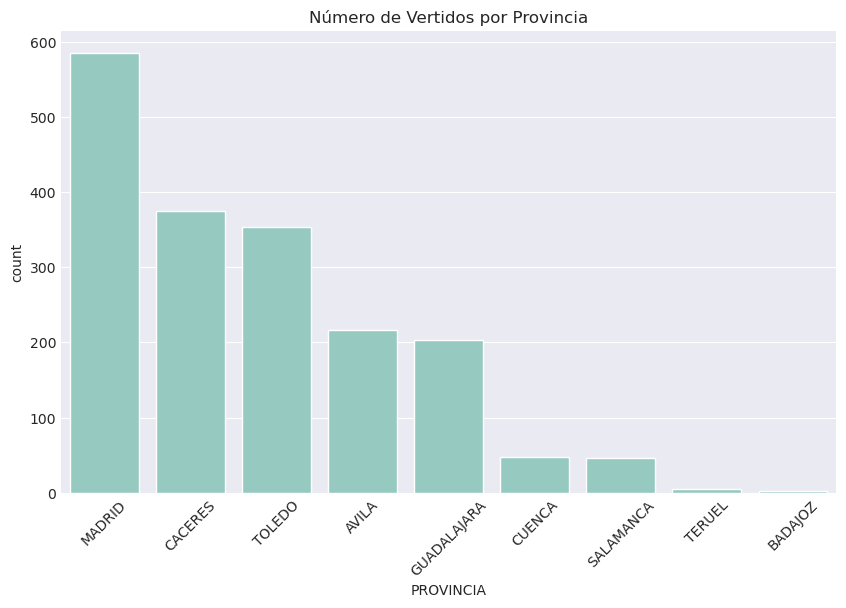

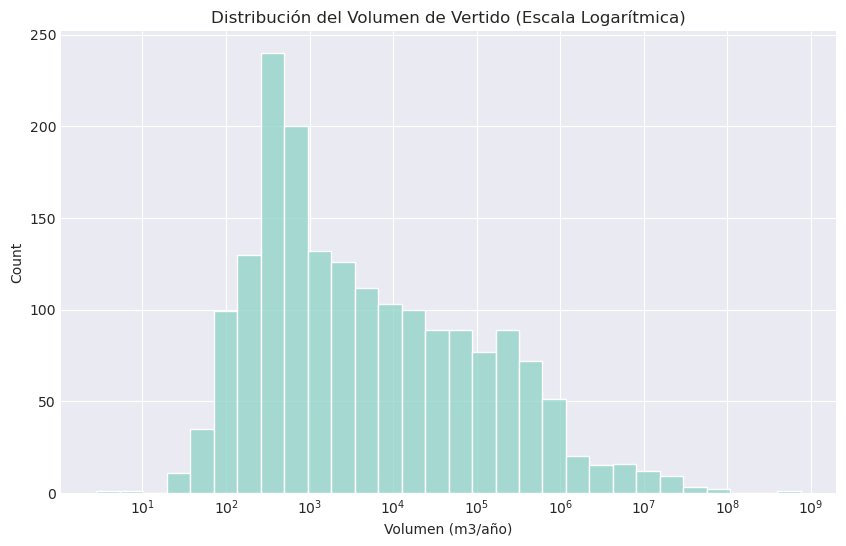

In [99]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='PROVINCIA', order=df['PROVINCIA'].value_counts().index)
plt.title('Número de Vertidos por Provincia')
plt.xticks(rotation=45)
plt.show()

# Distribución del Volumen en escala Logarítmica
plt.figure(figsize=(10, 6))
sns.histplot(df['VOLUMEN_m3_ano'], bins=30, log_scale=True)
plt.title('Distribución del Volumen de Vertido (Escala Logarítmica)')
plt.xlabel('Volumen (m3/año)')
plt.show()

In [100]:
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['UTM_X'], df['UTM_Y']),
    crs="EPSG:32630" # Proyección UTM Zona 30N
)

# Clustering Espacial basado en Densidad (DBSCAN)
# Identifica clústeres de vertidos geográficamente cercanos automáticamente
# eps=5000 (5km de radio), min_samples=3
coords = df[['UTM_X', 'UTM_Y']].values
db = DBSCAN(eps=5000, min_samples=3, algorithm='ball_tree').fit(coords)

# Guardamos el cluster en el gdf original
gdf['cluster_id'] = db.labels_

print("Cálculos y geometría UTM generados correctamente.")

Cálculos y geometría UTM generados correctamente.


In [101]:
# 1. Crear una copia temporal reproyectada a Lat/Lon (WGS84) para Folium
gdf_map = gdf.to_crs(epsg=4326)

# 2. Generar datos para el Heatmap
# Folium necesita [Latitud, Longitud, Peso].
# En WGS84: Latitud = Y, Longitud = X
heat_data = [
    [row.geometry.y, row.geometry.x, np.log1p(row['VOLUMEN_m3_ano'])]
    for index, row in gdf_map.iterrows()
    if not np.isnan(row.geometry.x) and not np.isnan(row.geometry.y) # Filtro de seguridad
]

print(f"Existen {len(heat_data)} puntos válidos para visualizar.")

# 3. Crear el mapa
m = folium.Map(location=[40.416, -3.703], zoom_start=7, tiles='CartoDB dark_matter')

HeatMap(heat_data, radius=15, blur=10).add_to(m)

m

Existen 1835 puntos válidos para visualizar.


# ANÁLISIS FORENSE DE AUTORIZADOS A VERTIDOS

In [102]:
df['log_vol'] = np.log1p(df['VOLUMEN_m3_ano'])
print(f"Dataset listo: {df.shape[0]} registros operativos.")

Dataset listo: 1835 registros operativos.


## Integridad de datos presentados

Aplicamos la Ley de Benford (Ley de los Primeros Dígitos) para verificar la naturalidad de los volúmenes reportados. En datos financieros o físicos reales, el dígito '1' debe aparecer ~30% de las veces. Una desviación significativa del patrón teórico (p<0.05) indica manipulación humana, estimación manual o invención de datos.

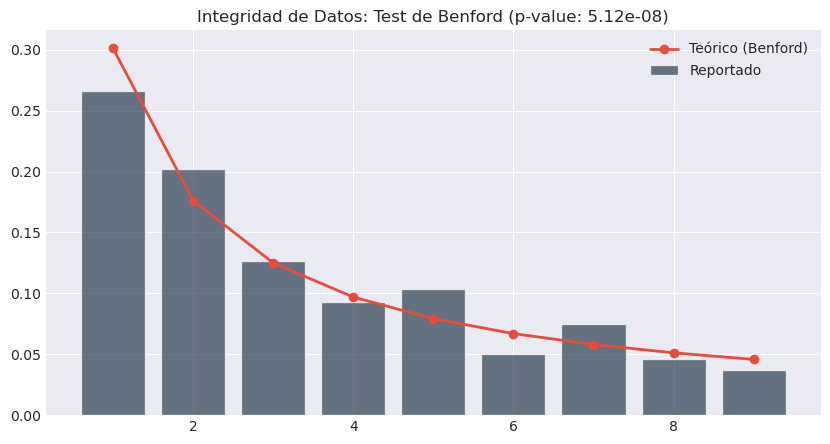

ALERTA: Los datos presentan evidencia estadística de manipulación o estimación manual.
INFO: p-valor 5.118926842628549e-08


In [103]:
def benford_audit(series):
    # Extracción del primer dígito significativo
    first_digits = series.astype(str).str.lstrip('0').str[0].astype(int)
    first_digits = first_digits[first_digits > 0]

    # Frecuencias observadas vs esperadas
    obs_counts = first_digits.value_counts().sort_index()
    total = obs_counts.sum()
    expected_probs = np.log10(1 + 1/np.arange(1, 10))
    exp_counts = expected_probs * total

    # Test estadístico de Chi-Cuadrado
    chi2, p_val = chisquare(obs_counts, f_exp=exp_counts)

    # Visualización
    plt.figure(figsize=(10, 5))
    plt.bar(np.arange(1, 10), obs_counts/total, label='Reportado', alpha=0.7, color='#2c3e50')
    plt.plot(np.arange(1, 10), expected_probs, color='#e74c3c', marker='o', linewidth=2, label='Teórico (Benford)')
    plt.title(f'Integridad de Datos: Test de Benford (p-value: {p_val:.2e})')
    plt.legend()
    plt.show()

    return p_val

p_value = benford_audit(df['VOLUMEN_m3_ano'])
if p_value < 0.05:
    print("ALERTA: Los datos presentan evidencia estadística de manipulación o estimación manual.")
    print(f"INFO: p-valor {p_value}")

En un conjunto de datos medidos por instrumentos reales, el último dígito (0-9) debe distribuirse uniformemente (10% de probabilidad cada uno). Los seres humanos, al estimar o inventar cifras, tienen un sesgo cognitivo masivo hacia el redondeo en 0 y 5. Este test revela qué porcentaje del censo son estimaciones

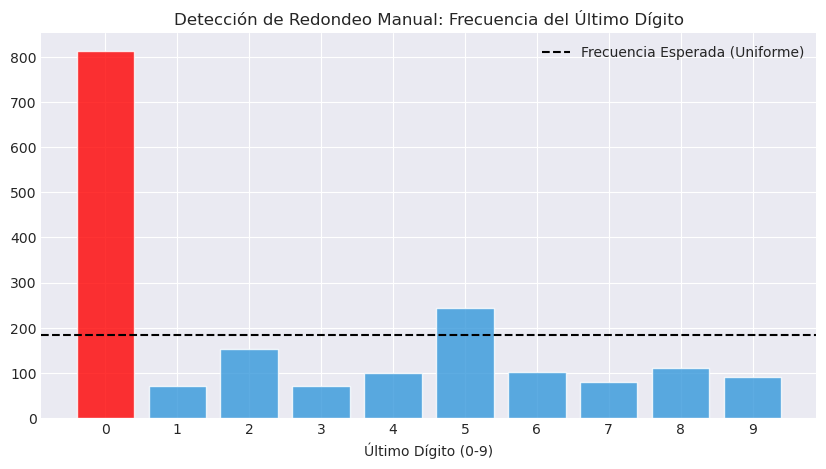

Sobre-representación del dígito '0': +342.5% (Indicio de redondeo masivo)


In [104]:
def terminal_digit_analysis(series):
    # Extraer el último dígito entero
    last_digits = series.dropna().apply(lambda x: int(str(int(x))[-1]))

    # Conteo
    counts = last_digits.value_counts().sort_index()

    # Visualización
    plt.figure(figsize=(10, 5))
    colors = ['red' if c > counts.mean() + counts.std() else '#3498db' for c in counts]
    plt.bar(counts.index, counts.values, color=colors, alpha=0.8)
    plt.axhline(y=len(series)/10, color='black', linestyle='--', label='Frecuencia Esperada (Uniforme)')
    plt.title('Detección de Redondeo Manual: Frecuencia del Último Dígito')
    plt.xticks(range(10))
    plt.xlabel('Último Dígito (0-9)')
    plt.legend()
    plt.show()

    # Cálculo de exceso de ceros
    zero_bias = (counts[0] - (len(series)/10)) / (len(series)/10) * 100
    print(f"Sobre-representación del dígito '0': +{zero_bias:.1f}% (Indicio de redondeo masivo)")

terminal_digit_analysis(df['VOLUMEN_m3_ano'])

Hemos detectado que muchos volúmenes son múltiplos exactos de 365. Esto indica que no se está midiendo el vertido real, sino que se toma un valor teórico diario (ej. 100 m3/día) y se multiplica por los días del año. Este snippet identifica automáticamente estas Fórmulas de Excel disfrazadas de Datos.

In [105]:
def spreadsheet_artifact_detector(series):
    # Verificar si el volumen es divisible por 365 (con margen de error mínimo)
    is_365_multiple = (series % 365 == 0) & (series > 0)

    # Identificar los patrones más comunes
    artifacts = series[is_365_multiple].value_counts().head(5)

    print(f"Total de registros generados por fórmula (X * 365): {is_365_multiple.sum()}")
    print("\nPatrones de repetición más comunes (Volumen Anual -> Estimación Diaria):")
    for vol, count in artifacts.items():
        daily = vol / 365
        print(f"  - {vol:,.0f} m3/año ({count} casos) -> Equivale a exactamente {daily:.0f} m3/día")

spreadsheet_artifact_detector(df['VOLUMEN_m3_ano'])

Total de registros generados por fórmula (X * 365): 528

Patrones de repetición más comunes (Volumen Anual -> Estimación Diaria):
  - 365 m3/año (57 casos) -> Equivale a exactamente 1 m3/día
  - 730 m3/año (27 casos) -> Equivale a exactamente 2 m3/día
  - 1,095 m3/año (20 casos) -> Equivale a exactamente 3 m3/día
  - 7,300 m3/año (19 casos) -> Equivale a exactamente 20 m3/día
  - 3,650 m3/año (18 casos) -> Equivale a exactamente 10 m3/día


Con 1830 registros esto indica que 1/3 de los registros son meras estimaciones y no datos reales

Procedemos a marcar esas filas como low fidelity porque si son calculadas es más improbable que reporten un exceso o accidente.

Se puede decidir si profundizar sobre esta vía o no

In [106]:
df['LOW_FIDELITY'] = (df['VOLUMEN_m3_ano'] % 365 == 0) & (df['VOLUMEN_m3_ano'] > 0)

In [107]:
df

,NOMBRE_VERTIDO,TITULAR,MUNICIPIO,PROVINCIA,UTM_X,UTM_Y,MEDIO_RECEPTOR,NATURALEZA_VERTIDO,CARACT_VERTIDO,VOLUMEN_m3_ano,NATURALEZA_RECEPTOR,REF_EXPEDIENTE,tipo_titular,log_vol,LOW_FIDELITY
0,DROMEN GESTORES Y CONSULTORES (VIV. UNIFAMILIAR),"DROMEN GESTORES Y CONSULTORES, S.L.",ADRADA (LA),AVILA,358144.0,4460601.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,231.0,CATEGORÍA I,AV-0006/2020,J,5.446737,False
1,PIZZERIA-RESTAURANTE PUENTE MOCHA,PERSONA FÍSICA,ADRADA (LA),AVILA,358290.0,4459633.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,1188.0,CATEGORÍA I,AV-0049/1999,F,7.080868,False
2,CENTRO HÍPICO LA ESPUELA,"CORPORACIÓN RILUMI, S.L.",ADRADA (LA),AVILA,358288.0,4459174.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,3650.0,CATEGORÍA I,AV-0041/2015,J,8.202756,True
3,EDAR LA ADRADA,AYUNTAMIENTO DE LA ADRADA,ADRADA (LA),AVILA,359461.0,4460939.0,ARROYO FRANQUILLO,URBANO O ASIMILABLE,2.000-10.000 h-e,1193058.0,CATEGORÍA I,AV-0053/2014,A,13.992031,False
4,PERSONA FÍSICA (VIVIENDAS),PERSONA FÍSICA,ADRADA (LA),AVILA,357353.0,4461118.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,102.0,CATEGORÍA I,AV-0041/2017,F,4.634729,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1830,CANTERA YEPES LAFARGE CEMENTOS (ASEOS),"LAFARGE CEMENTOS, S.A.U.",YEPES,TOLEDO,443626.0,4419156.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,312.0,CATEGORÍA I,AV-0054/2000,J,5.746203,False
1831,HOSTAL-RESTAURANTE EL RINCON - CASA MARCOS,"HOSTAL-RESTAURANTE EL RINCON, S.L.",YEPES,TOLEDO,436468.0,4421408.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,1424.0,CATEGORÍA I,AV-0113/2003,J,7.261927,False
1832,FABRICA CEMENTO CASTILLEJO CEMEX (ASEOS),"CEMEX ESPAÑA OPERACIONES, S.L.U.",YEPES,TOLEDO,436365.0,4420347.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,5840.0,CATEGORÍA I,AV-0022/1996,J,8.672657,True
1833,TALLER YUNCLER MOTOR (ASEOS),"YUNCLER MOTOR, S.L.",YUNCLER,TOLEDO,423618.0,4435868.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,182.0,CATEGORÍA I,AV-0024/2016,J,5.209486,False


In [108]:
df[df['LOW_FIDELITY']].groupby('tipo_titular').count()

,NOMBRE_VERTIDO,TITULAR,MUNICIPIO,PROVINCIA,UTM_X,UTM_Y,MEDIO_RECEPTOR,NATURALEZA_VERTIDO,CARACT_VERTIDO,VOLUMEN_m3_ano,NATURALEZA_RECEPTOR,REF_EXPEDIENTE,log_vol,LOW_FIDELITY
tipo_titular,,,,,,,,,,,,,,
A,236,236,236,236,236,236,236,236,236,236,236,236,236,236
F,70,70,70,70,70,70,70,70,70,70,70,70,70,70
J,222,222,222,222,222,222,222,222,222,222,222,222,222,222


Tanto ayuntamientos como agrupaciones privadas o personas físicas caen en esta catogoría

In [109]:
print(df.groupby('PROVINCIA').count()['NOMBRE_VERTIDO'])
print(df[df['LOW_FIDELITY']].groupby('PROVINCIA').count()['NOMBRE_VERTIDO'])

df[df['LOW_FIDELITY']].groupby('PROVINCIA').count()['NOMBRE_VERTIDO']/df.groupby('PROVINCIA').count()['NOMBRE_VERTIDO']

PROVINCIA
AVILA          217
BADAJOZ          2
CACERES        375
CUENCA          48
GUADALAJARA    203
MADRID         585
SALAMANCA       46
TERUEL           5
TOLEDO         354
Name: NOMBRE_VERTIDO, dtype: int64
PROVINCIA
AVILA           29
CACERES        118
CUENCA           8
GUADALAJARA     55
MADRID         177
SALAMANCA        5
TERUEL           1
TOLEDO         135
Name: NOMBRE_VERTIDO, dtype: int64


PROVINCIA
AVILA          0.133641
BADAJOZ             NaN
CACERES        0.314667
CUENCA         0.166667
GUADALAJARA    0.270936
MADRID         0.302564
SALAMANCA      0.108696
TERUEL         0.200000
TOLEDO         0.381356
Name: NOMBRE_VERTIDO, dtype: float64

## Aislamiento de ouliers

Utilizamos un algoritmo de Isolation Forest para detectar outliers multidimensionales. A diferencia de un simple filtro por volumen, este modelo cruza la ubicación (UTM X, Y) con el volumen. Identifica vertidos que son anormales para su ubicación o magnitud relativa, aislando casos como Persona Física con volúmenes industriales.


In [110]:
features = df[['UTM_X', 'UTM_Y', 'log_vol']].fillna(0)

# Configuración del modelo: Contaminación estimada del 1% (casos extremos)
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=69420)
df['anomaly_score'] = iso_forest.fit_predict(features)

# Filtrado de anomalías (score = -1)
anomalies = df[df['anomaly_score'] == -1].sort_values('VOLUMEN_m3_ano', ascending=False)

print("Top 5 Anomalías detectadas por el algoritmo:")
display(anomalies[['MUNICIPIO', 'TITULAR', 'VOLUMEN_m3_ano', 'NATURALEZA_VERTIDO']].head())

Top 5 Anomalías detectadas por el algoritmo:


,MUNICIPIO,TITULAR,VOLUMEN_m3_ano,NATURALEZA_VERTIDO
668,ANGUITA,PERSONA FÍSICA,15768000.0,INDUSTRIAL
266,CACERES,AYUNTAMIENTO DE CÁCERES,9896341.0,URBANO O ASIMILABLE
217,SAN VICENTE DE ALCANTARA,AYUNTAMIENTO DE SAN VICENTE DE ALCANTARA,680000.0,URBANO O ASIMILABLE
549,VALENCIA DE ALCANTARA,AYUNTAMIENTO DE VALENCIA DE ALCANTARA,655106.0,URBANO O ASIMILABLE
240,ALCUESCAR,AYUNTAMIENTO DE ALCUESCAR,306089.0,URBANO O ASIMILABLE


Antes de juzgar lo anormal, debemos definir rigurosamente lo normal. Utilizando los inliers (datos no anómalos) clasificados por el algoritmo Isolation Forest previo, construimos el perfil del vertido estándar. Cualquier desviación futura se medirá contra esta Línea Base Operativa.

=== PERFIL OPERATIVO: VERTIDO ESTÁNDAR (BASELINE) ===
Volumen Mediano (Típico):      2395.00 m3/año
Umbral Superior (95% casos):   934957.75 m3/año
Moda - Naturaleza:             URBANO O ASIMILABLE
Moda - Medio Receptor:         TERRENO


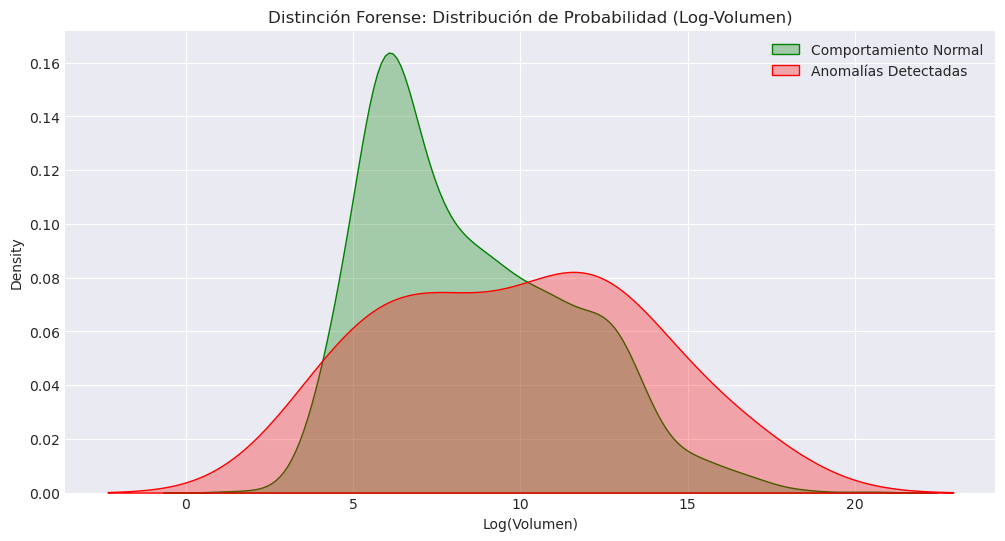

In [111]:
normal_population = df[df['anomaly_score'] == 1]  # Inliers
anomalous_population = df[df['anomaly_score'] == -1]  # Outliers

print("=== PERFIL OPERATIVO: VERTIDO ESTÁNDAR (BASELINE) ===")
stats = normal_population['VOLUMEN_m3_ano'].describe(percentiles=[0.25, 0.5, 0.75, 0.95])

print(f"Volumen Mediano (Típico):      {stats['50%']:.2f} m3/año")
print(f"Umbral Superior (95% casos):   {stats['95%']:.2f} m3/año")
print(f"Moda - Naturaleza:             {normal_population['NATURALEZA_VERTIDO'].mode()[0]}")
print(f"Moda - Medio Receptor:         {normal_population['MEDIO_RECEPTOR'].mode()[0]}")

# Visualización comparativa: Normalidad vs Anomalía
plt.figure(figsize=(12, 6))
sns.kdeplot(np.log1p(normal_population['VOLUMEN_m3_ano']), fill=True, color='green', label='Comportamiento Normal', alpha=0.3)
sns.kdeplot(np.log1p(anomalous_population['VOLUMEN_m3_ano']), fill=True, color='red', label='Anomalías Detectadas', alpha=0.3)
plt.title('Distinción Forense: Distribución de Probabilidad (Log-Volumen)')
plt.xlabel('Log(Volumen)')
plt.legend()
plt.show()

A diferencia del Isolation Forest (que busca anomalías globales), el LOF (Local Outlier Factor) busca desviaciones de densidad local. Detecta: Un vertido que, aunque no sea enorme en volumen absoluto, es sospechosamente grande comparado con sus vecinos geográficos. Es ideal para encontrar industrias ocultas en zonas rurales o residenciales.

In [112]:
# Configuración: Analizamos la densidad local con 20 vecinos más cercanos
# Contaminación 1%: Buscamos solo las desviaciones más flagrantes
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)

# Features: Coordenadas y Volumen
features_lof = df[['UTM_X', 'UTM_Y', 'log_vol']].fillna(0)
df['lof_score'] = lof.fit_predict(features_lof)
df['lof_negative_factor'] = lof.negative_outlier_factor_ # Cuanto más negativo, más anómalo

# Extracción de Anomalías Contextuales
context_anomalies = df[df['lof_score'] == -1].sort_values('lof_negative_factor')

print("=== ANOMALÍAS CONTEXTUALES (LOF) ===")
print("Objetivos que destacan inusualmente respecto a su entorno inmediato:")
display(context_anomalies[['MUNICIPIO', 'TITULAR', 'VOLUMEN_m3_ano', 'lof_negative_factor']].head(5))

=== ANOMALÍAS CONTEXTUALES (LOF) ===
Objetivos que destacan inusualmente respecto a su entorno inmediato:


,MUNICIPIO,TITULAR,VOLUMEN_m3_ano,lof_negative_factor
136,CEPEDA LA MORA,PERSONA FÍSICA,130.0,-2.266951
1455,MEMBRIBE DE LA SIERRA,AYUNTAMIENTO DE MEMBRIBE DE LA SIERRA,6420.0,-2.193227
1677,OROPESA,INFRAESTRUCTURAS DEL AGUA DE CASTILLA-LA MANCHA,61000.0,-2.148540
1678,OROPESA,PERSONA FÍSICA,10000.0,-2.034373
216,VILLAREJO DEL VALLE,MINISTERIO PARA LA TRANSICIÓN ECOLÓGICA Y RETO...,5132.5,-2.003873


Vamos a expluir a las entidades públicas de la búsqueda

In [113]:
# Configuración: Analizamos la densidad local con 20 vecinos más cercanos
# Contaminación 1%: Buscamos solo las desviaciones más flagrantes
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
tmp = df[df['tipo_titular']!='A'] # Excluir a las Admins públicas
# Features: Coordenadas y Volumen
features_lof = tmp[['UTM_X', 'UTM_Y', 'log_vol']].fillna(0)
tmp['lof_score'] = lof.fit_predict(features_lof)
tmp['lof_negative_factor'] = lof.negative_outlier_factor_ # Cuanto más negativo, más anómalo

# Extracción de Anomalías Contextuales
context_anomalies = tmp[tmp['lof_score'] == -1].sort_values('lof_negative_factor')

print("=== ANOMALÍAS CONTEXTUALES (LOF) ===")
print("Objetivos que destacan inusualmente respecto a su entorno inmediato:")
display(context_anomalies[['MUNICIPIO', 'TITULAR', 'VOLUMEN_m3_ano', 'lof_negative_factor']].head(10))

=== ANOMALÍAS CONTEXTUALES (LOF) ===
Objetivos que destacan inusualmente respecto a su entorno inmediato:


/tmp/ipykernel_5532/4229307537.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['lof_score'] = lof.fit_predict(features_lof)
/tmp/ipykernel_5532/4229307537.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['lof_negative_factor'] = lof.negative_outlier_factor_ # Cuanto más negativo, más anómalo


,MUNICIPIO,TITULAR,VOLUMEN_m3_ano,lof_negative_factor
310,CEDILLO,"IBERDROLA GENERACION, S.A.U.",770.88,-2.772658
307,CEDILLO,"IBERDROLA GENERACION, S.A.U.",274.00,-2.770612
308,CEDILLO,"IBERDROLA GENERACION, S.A.U.",1095.00,-2.748021
1524,CAMARENA,PERSONA FÍSICA,532.00,-2.504822
136,CEPEDA LA MORA,PERSONA FÍSICA,130.00,-2.277209
1498,ARCICOLLAR,PERSONA FÍSICA,55.00,-2.124827
237,ALCANTARA,"ENCE ENERGÍA EXTREMADURA DOS, S.L.",113530.00,-2.109429
235,ALCANTARA,"IBERDROLA GENERACION, S.A.U.",20075.00,-2.083273
239,ALCANTARA,"IBERDROLA GENERACION, S.A.U.",823.00,-2.076532
1536,CASARRUBIOS DEL MONTE,"AEROHOBBY AVIACIÓN DEPORTIVA, S.L.",7300.00,-2.066764


TODO AQUÍ SE PEUDE HACER UNA HERRAMIENTA POR EJEMPLO PARA VISUALIZAR EL ENTORNO INMEDIATO DE LAS PERSONAS FÍSICAS INVOLUCARAS

## Análisis espacial

Ejecutamos DBSCAN (Density-Based Spatial Clustering) para identificar puntos calientes o zonas de sacrificio. Agrupa vertidos geográficamente cercanos (radio de 2km) para detectar acumulación de carga contaminante que individualmente pasaría desapercibida pero que colectivamente satura el medio receptor.

In [114]:
coords = df[['UTM_X', 'UTM_Y']]
db = DBSCAN(eps=2000, min_samples=5).fit(coords)
df['spatial_cluster'] = db.labels_

# Análisis de clusters (excluyendo ruido -1)
cluster_analysis = df[df['spatial_cluster'] != -1].groupby('spatial_cluster').agg({
    'VOLUMEN_m3_ano': 'sum',
    'TITULAR': 'count',
    'MUNICIPIO': lambda x: x.mode()[0]
}).sort_values('VOLUMEN_m3_ano', ascending=False)

print("Zonas de mayor presión hídrica acumulada:")
display(cluster_analysis.head(5))

Zonas de mayor presión hídrica acumulada:


,VOLUMEN_m3_ano,TITULAR,MUNICIPIO
spatial_cluster,,,
10,758190297.0,7,ALMARAZ
22,10145714.0,5,ALCOBENDAS
25,8025349.0,21,SAN SEBASTIAN DE LOS REYES
48,3455080.0,5,VILLASECA DE LA SAGRA
26,2157500.0,9,FUENTE EL SAZ DE JARAMA


# Autorizados a verter X red de sensores SAICA

El objetivo de esta sección es lograr generar un grafo dirigido para relacionar los autorizados del censo con los sensores que podrían detectar los vertidos

In [115]:
df.columns

Index(['NOMBRE_VERTIDO', 'TITULAR', 'MUNICIPIO', 'PROVINCIA', 'UTM_X', 'UTM_Y',
       'MEDIO_RECEPTOR', 'NATURALEZA_VERTIDO', 'CARACT_VERTIDO',
       'VOLUMEN_m3_ano', 'NATURALEZA_RECEPTOR', 'REF_EXPEDIENTE',
       'tipo_titular', 'log_vol', 'LOW_FIDELITY', 'anomaly_score', 'lof_score',
       'lof_negative_factor', 'spatial_cluster'],
      dtype='object')

In [116]:
df.head()

,NOMBRE_VERTIDO,TITULAR,MUNICIPIO,PROVINCIA,UTM_X,UTM_Y,MEDIO_RECEPTOR,NATURALEZA_VERTIDO,CARACT_VERTIDO,VOLUMEN_m3_ano,NATURALEZA_RECEPTOR,REF_EXPEDIENTE,tipo_titular,log_vol,LOW_FIDELITY,anomaly_score,lof_score,lof_negative_factor,spatial_cluster
0,DROMEN GESTORES Y CONSULTORES (VIV. UNIFAMILIAR),"DROMEN GESTORES Y CONSULTORES, S.L.",ADRADA (LA),AVILA,358144.0,4460601.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,231.0,CATEGORÍA I,AV-0006/2020,J,5.446737,False,1,1,-1.210545,0
1,PIZZERIA-RESTAURANTE PUENTE MOCHA,PERSONA FÍSICA,ADRADA (LA),AVILA,358290.0,4459633.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,1188.0,CATEGORÍA I,AV-0049/1999,F,7.080868,False,1,1,-1.210084,0
2,CENTRO HÍPICO LA ESPUELA,"CORPORACIÓN RILUMI, S.L.",ADRADA (LA),AVILA,358288.0,4459174.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,3650.0,CATEGORÍA I,AV-0041/2015,J,8.202756,True,1,1,-1.203118,0
3,EDAR LA ADRADA,AYUNTAMIENTO DE LA ADRADA,ADRADA (LA),AVILA,359461.0,4460939.0,ARROYO FRANQUILLO,URBANO O ASIMILABLE,2.000-10.000 h-e,1193058.0,CATEGORÍA I,AV-0053/2014,A,13.992031,False,1,1,-1.211816,0
4,PERSONA FÍSICA (VIVIENDAS),PERSONA FÍSICA,ADRADA (LA),AVILA,357353.0,4461118.0,TERRENO,URBANO O ASIMILABLE,<2.000 h-e,102.0,CATEGORÍA I,AV-0041/2017,F,4.634729,False,1,1,-1.176477,0


Importamos las estaciones con sus coordenadas

In [117]:
stations = pd.read_json("/tmp/pycharm_project_992/data/datasets/raw/saica_stations_maestro_coords.json")

stations = stations.rename(columns={'codigo': 'id_estacion'})

stations['utm_x'] = pd.to_numeric(stations['utm_x'], errors='coerce')
stations['utm_y'] = pd.to_numeric(stations['utm_y'], errors='coerce')

stations = stations.dropna(subset=['utm_x', 'utm_y'])

stations.head()

,id_estacion,nombre,subcuenca,url_detalles,utm_x,utm_y,huso
0,C322,SAICA CARCABOSO,ALAGÓN,https://saihtajo.chtajo.es/index.php?w=get-est...,226397,4437976.0,30
1,C323,SAICA BEJAR,ALAGÓN,https://saihtajo.chtajo.es/index.php?w=get-est...,262857,4474673.0,30
2,C313,SAICA CAZALEGAS,ALBERCHE,https://saihtajo.chtajo.es/index.php?w=get-est...,354250,4430700.0,30
3,C326,SAICA ESCALONA,ALBERCHE,https://saihtajo.chtajo.es/index.php?w=get-est...,380680,4447011.0,30
4,C342,SAICA PICADAS,ALBERCHE,https://saihtajo.chtajo.es/index.php?w=get-est...,393858,4465945.0,30


Realizamos un análisis inicial a ver qué tan cerca están los autorizados de los sensores. Estos más adelante los vamos a clasificar como alta_sensibilidad

In [118]:
coords_v = df[['UTM_X', 'UTM_Y']].values
coords_s = stations[['utm_x', 'utm_y']].values

distancias = cdist(coords_v, coords_s, metric='euclidean')

umbral_metros = 5000
indices_v, indices_s = np.where(distancias < umbral_metros)

relaciones = pd.DataFrame({
    'source_id': df.iloc[indices_v]['REF_EXPEDIENTE'].values,
    'target_id': stations.iloc[indices_s]['id_estacion'].values,
    'distancia': distancias[indices_v, indices_s].round(2),
    'tipo_relacion': 'CERCANO_A'
})

print(f"Detectadas {len(relaciones)} conexiones de riesgo (distancia < 5km)")
relaciones.head()

Detectadas 212 conexiones de riesgo (distancia < 5km)


,source_id,target_id,distancia,tipo_relacion
0,AV-0166/2005,C317,4289.00,CERCANO_A
1,AV-0167/2005,C317,4289.00,CERCANO_A
2,AV-0189/2007,C317,4219.25,CERCANO_A
3,AV-0190/2007,C317,4766.89,CERCANO_A
4,AV-0061/2019,C322,607.99,CERCANO_A


Vamos a analizar la densidad de la red de sensores

In [119]:
coords_s = stations[['utm_x', 'utm_y']].values
dist_matrix_sensors = cdist(coords_s, coords_s, metric='euclidean')

# Rellenar diagonal con infinito para no encontrar distancia 0 a sí mismo
np.fill_diagonal(dist_matrix_sensors, np.inf)

# Distancia al vecino más cercano para cada sensor
min_dist_sensors = dist_matrix_sensors.min(axis=1)

print("--- ANÁLISIS DE DENSIDAD DE SENSORES (Resolución de la red) ---")
print(f"Distancia MÍNIMA entre dos sensores: {min_dist_sensors.min()/1000:.2f} km")
print(f"Distancia MEDIA al sensor vecino: {min_dist_sensors.mean()/1000:.2f} km")
print(f"Distancia MAXIMA (hueco más grande): {min_dist_sensors.max()/1000:.2f} km")

--- ANÁLISIS DE DENSIDAD DE SENSORES (Resolución de la red) ---
Distancia MÍNIMA entre dos sensores: 0.60 km
Distancia MEDIA al sensor vecino: 20.48 km
Distancia MAXIMA (hueco más grande): 93.81 km


Análisis 2: Cobertura de Vertidos (Source-to-nearest-Sensor)

In [120]:
coords_v = df[['UTM_X', 'UTM_Y']].values
dist_matrix_vs = cdist(coords_v, coords_s, metric='euclidean')

# Distancia al sensor más cercano para cada vertido (k=1)
min_dist_vertidos = dist_matrix_vs.min(axis=1)

print("\n--- ANÁLISIS DE COBERTURA (Situación real de los vertidos) ---")
print(f"Vertido más cercano a un sensor: {min_dist_vertidos.min():.2f} metros")
print(f"Vertido más lejano a un sensor (Huérfano extremo): {min_dist_vertidos.max()/1000:.2f} km")
print(f"Mediana de distancia (El 50% está a menos de...): {np.median(min_dist_vertidos)/1000:.2f} km")
print(f"Percentil 75 (La mayoría está a menos de...): {np.percentile(min_dist_vertidos, 75)/1000:.2f} km")

# Contar cuántos entran en diferentes radios
r5 = np.sum(min_dist_vertidos < 5000)
r10 = np.sum(min_dist_vertidos < 10000)
r20 = np.sum(min_dist_vertidos < 20000)
total = len(df)

print(f"\n--- CLASIFICACIÓN POTENCIAL ---")
print(f"Radio < 5 km: {r5} vertidos ({r5/total:.1%})")
print(f"Radio < 10 km: {r10} vertidos ({r10/total:.1%})")
print(f"Radio < 20 km: {r20} vertidos ({r20/total:.1%})")


--- ANÁLISIS DE COBERTURA (Situación real de los vertidos) ---
Vertido más cercano a un sensor: 3.00 metros
Vertido más lejano a un sensor (Huérfano extremo): 92.09 km
Mediana de distancia (El 50% está a menos de...): 17.97 km
Percentil 75 (La mayoría está a menos de...): 30.91 km

--- CLASIFICACIÓN POTENCIAL ---
Radio < 5 km: 197 vertidos (10.7%)
Radio < 10 km: 454 vertidos (24.7%)
Radio < 20 km: 1025 vertidos (55.9%)


Vamos a ver si podemos clasificar por cercanía y sensor ya que ahora mismo la dimensionalidad del dato nos limita un poco en el análisis.  más adelante para hacer el grafo vamos a hacer lo siguiente. Calculamos el punto más cerca del río de cada autorizado a verter, y a partir de ahí le asignamos un sensor aguas abajo

Pedimos relaciones o vías llamadas "Río Tajo" que sean cursos de agua

In [121]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
(
  way["waterway"="river"]["name"="Río Tajo"](39.0,-6.0,41.0,-1.5);
);
out geom;
"""

He puesto una Bounding Box (39,-6,41,-1.5) aproximada de la cuenca alta/media, para no traernos el Tajo en Portugal y reducir ruido, pero podemos quitarla

Descargando geometría del Tajo desde OSM...
Tajo descargado y reproyectado a UTM 30N.
Longitud total del tramo capturado: 716.51 km


<Axes: >

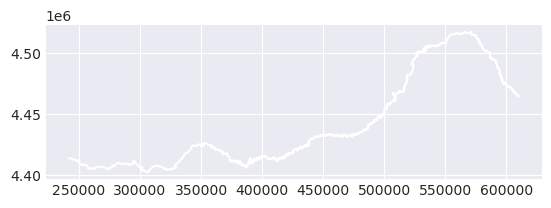

In [122]:
print("Descargando geometría del Tajo desde OSM...")
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

# Convertir respuesta JSON a Geometría
coords_list = []
for element in data['elements']:
    if 'geometry' in element:
        # Extraemos pares (lon, lat)
        points = [(pt['lon'], pt['lat']) for pt in element['geometry']]
        coords_list.append(LineString(points))

# Unimos todos los tramos sueltos en una sola línea continua
if coords_list:
    rio_tajo_bruto = linemerge(MultiLineString(coords_list))

    # Crear GeoDataFrame
    gdf_rio = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[rio_tajo_bruto])

    # REPROYECCIÓN CRÍTICA: A UTM 30N (Para coincidir con el dataset)
    gdf_rio_utm = gdf_rio.to_crs(epsg=32630) # UTM Zone 30N

    rio_geom = gdf_rio_utm.geometry[0]

    print("Tajo descargado y reproyectado a UTM 30N.")
    print(f"Longitud total del tramo capturado: {rio_geom.length/1000:.2f} km")
else:
    print("No se encontraron datos. Revisa la query.")

# Visualización rápida para confirmar
gdf_rio_utm.plot()

Exportar a csv para uso futuro por compañeros

In [123]:
# gdf_rio_utm.to_csv("/tmp/pycharm_project_992/data/datasets/raw/linestring_tajo.csv")

Función de proyección hidráulica. Comenzamos definiendo la función matemática que proyectará nuestros puntos (vertidos y sensores) sobre la línea del río para obtener su posición kilométrica exacta.

In [124]:
def get_hydro_metrics(row, geom, x_col, y_col):
    """
    Proyecta un punto (UTM) sobre la línea del río.
    Retorna:
      - km_rio: Distancia desde el nacimiento hasta el punto proyectado.
      - dist_al_rio: Distancia perpendicular desde el vertido hasta la orilla.
    """
    pt = Point(row[x_col], row[y_col])
    return pd.Series([geom.project(pt), pt.distance(geom)], index=['km_rio', 'dist_al_rio'])

Aplicamos esta función a los dos DataFrames. Esto nos dará dos nuevas columnas críticas: km_rio (punto exacto del cauce) y dist_al_rio (distancia lateral a la orilla).

In [125]:
df[['km_rio', 'dist_al_rio']] = df.apply(
    get_hydro_metrics,
    axis=1,
    args=(rio_geom, 'UTM_X', 'UTM_Y')
)

stations[['km_rio', 'dist_al_rio']] = stations.apply(
    get_hydro_metrics,
    axis=1,
    args=(rio_geom, 'utm_x', 'utm_y')
)

Ahora ejecutamos la lógica de asignación. Filtramos solo los elementos que estén cerca del cauce principal (margen de 3 km) y para cada vertido buscamos el primer sensor que se encuentre aguas abajo (donde el kilometraje del sensor sea mayor que el del vertido).

In [126]:
UMBRAL_RIBERA = 3000
df_rio = df[df['dist_al_rio'] < UMBRAL_RIBERA].copy()
stations_rio = stations[stations['dist_al_rio'] < UMBRAL_RIBERA].copy()

stations_rio = stations_rio.sort_values('km_rio')

rels_hidro = []

for idx, vertido in df_rio.iterrows():
    sensores_downstream = stations_rio[stations_rio['km_rio'] > vertido['km_rio']]

    if not sensores_downstream.empty:
        sensor_dest = sensores_downstream.iloc[0]

        distancia_agua = sensor_dest['km_rio'] - vertido['km_rio']

        rels_hidro.append({
            'source_id': vertido['REF_EXPEDIENTE'],
            'target_id': sensor_dest['id_estacion'],
            'distancia': round(distancia_agua, 2),
            'tipo_relacion': 'AGUAS_ABAJO'
        })

df_relaciones_rio = pd.DataFrame(rels_hidro)
df_relaciones_rio.head()

,source_id,target_id,distancia,tipo_relacion
0,AV-0189/2007,C317,3859.03,AGUAS_ABAJO
1,AV-0200/2008,C343,28350.66,AGUAS_ABAJO
2,AV-0174/2005,C317,3859.03,AGUAS_ABAJO
3,AV-0166/2003,C316,158408.97,AGUAS_ABAJO
4,AV-0145/2004,C325,41.46,AGUAS_ABAJO


Para completar la inteligencia del grafo, nos falta la Capa de Atribución. Ya sabemos dónde está el peligro (Espacial) y a dónde va (Hidráulica), pero no sabemos quién es el responsable ni quién tiene la jurisdicción.

In [127]:
# Normalizamos el nombre del titular para evitar duplicados por espacios o mayúsculas
df['TITULAR_NORM'] = df['TITULAR'].str.strip().str.upper()

# Creamos la tabla de relaciones
rel_titular = df[['REF_EXPEDIENTE', 'TITULAR_NORM']].copy()
rel_titular.columns = ['source_id', 'target_id']
rel_titular['tipo_relacion'] = 'TIENE_TITULAR'

Relación de jurisdicción

In [128]:
df['MUNICIPIO_NORM'] = df['MUNICIPIO'].str.strip().str.upper()

rel_municipio = df[['REF_EXPEDIENTE', 'MUNICIPIO_NORM']].copy()
rel_municipio.columns = ['source_id', 'target_id']
rel_municipio['tipo_relacion'] = 'EN_MUNICIPIO'



Consolidación final para el grafo

In [129]:
dfs_aristas = [
    relaciones,          # Proximidad (calculada previamente)
    df_relaciones_rio,   # Hidráulica (calculada previamente)
    rel_titular,         # Administrativa (Titular)
    rel_municipio        # Administrativa (Municipio)
]

# Concatenamos y limpiamos duplicados si los hubiera
all_edges = pd.concat(dfs_aristas, ignore_index=True)

print(f"Total del censo: {len(df)}")
print(f"Total de sensores: {len(stations)}")
print(f"Grafo total construido: {len(all_edges)} relaciones.")
print(all_edges['tipo_relacion'].value_counts())

# Vista previa
all_edges.head()

Total del censo: 1835
Total de sensores: 30
Grafo total construido: 4028 relaciones.
tipo_relacion
EN_MUNICIPIO     1835
TIENE_TITULAR    1835
CERCANO_A         212
AGUAS_ABAJO       146
Name: count, dtype: int64


,source_id,target_id,distancia,tipo_relacion
0,AV-0166/2005,C317,4289.00,CERCANO_A
1,AV-0167/2005,C317,4289.00,CERCANO_A
2,AV-0189/2007,C317,4219.25,CERCANO_A
3,AV-0190/2007,C317,4766.89,CERCANO_A
4,AV-0061/2019,C322,607.99,CERCANO_A


De 1835 nodos vemos que no todos vierten al cuerpo principal. Vamos a agregar más información aquí sobre afluyente para poder trabajar mejor.

In [130]:
df['MEDIO_RECEPTOR'].unique()

array(['TERRENO', 'ARROYO FRANQUILLO', 'RÍO EL ARENAL',
       'ARROYO BARRITOTE', 'ARROYO EGIDO', 'RÍO ALBERCHE',
       'ARROYO DE LA PARRA', 'ARROYO DE LOS CHARQUILLOS',
       'GARGANTA DE IRUELAS', 'ARROYO NOGALERA', 'ARROYO DE VALDIBUJO',
       'REGUERO DE LAS POZAS', 'ARROYO DE VALDEMARQUINA',
       'ARROYO DE LOS GALAYOS', 'GARGANTA DE LAS TORRES', 'ARROYO PELAYO',
       'RÍO CANTOS', 'ARROYO DE LA PEGUERA', 'ARROYO MERDERO',
       'ARROYO NAVAHERMOSA', 'RÍO RAMACASTAÑAS', 'ARROYO LAS HUERTAS',
       'ARROYO LOS MORALES', 'ARROYO PRADOMOLINO', 'GARGANTA CABRERA',
       'ARROYO CONEJERO', 'ARROYO DEL REGAJO', 'ARROYO DE LAS CASAS',
       'ARROYO DE VALLE ENMEDIO', 'RÍO ACEÑA', 'GARGANTA NUÑO COJO',
       'BARRANCO VALLE', 'RÍO TIÉTAR', 'RÍO PIQUILLO',
       'ARROYO DE FUENTE HERRADA', 'RÍO AMBROZ',
       'ARROYO DE LA FUENTE DE LA ESCOBA', 'ARROYO BARQUERA',
       'ARROYO BARRIGADILLA', 'ARROYO PALOMERO', 'ARROYO LA PILETA',
       'RÍO TAJO', 'ARROYO ROAGREA', 'ARROY

Primero, contamos la frecuencia de cada río en el Censo para priorizar la descarga. No gastaremos recursos en un arroyo con un solo vertido, nos centraremos en los cauces que estructuran la cuenca.

In [131]:
top_rios = df['MEDIO_RECEPTOR'].value_counts().reset_index()
top_rios.columns = ['nombre_rio', 'num_vertidos']

# Filtramos solo los que contienen la palabra RIO para evitar arroyos menores o TERRENO
rios_objetivo = top_rios[
    (top_rios['nombre_rio'].str.contains('RÍO', na=False)) &
    (top_rios['num_vertidos'] >= 10)
    ].copy()

print(f"Identificados {len(rios_objetivo)} afluentes principales para descarga.")
print(rios_objetivo.head(10))

# Preparamos una lista limpia de nombres para la API (Title Case para OSM: "Río Jarama")
# Como OSM es sensible a mayúsculas/tildes. Convertimos "RÍO JARAMA" -> "Río Jarama"
def limpiar_nombre(nombre):
    return nombre.title()

lista_rios_a_descargar = rios_objetivo['nombre_rio'].apply(limpiar_nombre).tolist()
# Aseguramos que el Tajo esté incluido si no saliera el primero
if "Río Tajo" not in lista_rios_a_descargar:
    lista_rios_a_descargar.insert(0, "Río Tajo")

print(f"\nLista de descarga preparada: {lista_rios_a_descargar}")

Identificados 6 afluentes principales para descarga.
       nombre_rio  num_vertidos
1        RÍO TAJO            55
3      RÍO JARAMA            27
4    RÍO ALBERCHE            21
5     RÍO HENARES            20
6      RÍO TAJUÑA            15
7  RÍO GUADARRAMA            13

Lista de descarga preparada: ['Río Tajo', 'Río Jarama', 'Río Alberche', 'Río Henares', 'Río Tajuña', 'Río Guadarrama']


procedemos a descargarnos las geometrías. Verificaremos si ya tenemos el csv descargado par ano volver a descargar y haremos varios intentos en caso de no tenerlo en local

In [132]:
output_dir = "/tmp/pycharm_project_992/data/datasets/raw/"
os.makedirs(output_dir, exist_ok=True)
geo_rios = {}

print("Iniciando procesamiento de geometrías...")

for nombre_rio in lista_rios_a_descargar:
    safe_name = nombre_rio.lower().replace(" ", "_")
    filename = f"linestring_{safe_name}.csv"
    filepath = os.path.join(output_dir, filename)

    print(f"Procesando: {nombre_rio}...", end=" ")

    if os.path.exists(filepath):
        try:
            df_temp = pd.read_csv(filepath)
            geometry_wkt = df_temp.iloc[0]['geometry']
            geo_rios[nombre_rio.upper()] = wkt.loads(geometry_wkt)
            print("Cargado desde disco.")
        except Exception as e:
            print(f"Error leyendo archivo existente: {e}")
        continue

    max_retries = 5
    descarga_exitosa = False

    for intento in range(max_retries):
        query = f"""
        [out:json][timeout:180][maxsize:1073741824];
        (
          way["waterway"="river"]["name"="{nombre_rio}"](39.0,-7.0,41.5,-1.0);
        );
        out geom;
        """

        try:
            response = requests.get(overpass_url, params={'data': query}, timeout=200)

            if response.status_code == 200:
                data = response.json()
                coords_list = []

                if 'elements' in data:
                    for element in data['elements']:
                        if 'geometry' in element:
                            points = [(pt['lon'], pt['lat']) for pt in element['geometry']]
                            coords_list.append(LineString(points))

                if coords_list:
                    linea_bruta = linemerge(MultiLineString(coords_list))
                    gdf_temp = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[linea_bruta])
                    gdf_temp = gdf_temp.to_crs(epsg=32630)

                    gdf_temp.to_csv(filepath, index=False)

                    geo_rios[nombre_rio.upper()] = gdf_temp.geometry[0]

                    dist_km = gdf_temp.geometry[0].length / 1000
                    print(f"Descargado OK ({dist_km:.1f} km)")
                    descarga_exitosa = True
                    break
                else:
                    print("Vacío (sin geometría)")
                    break

            elif response.status_code == 429:
                wait_time = 10 + (intento * 5)
                print(f"(429 - Esperando {wait_time}s)...", end=" ")
                time.sleep(wait_time)
            else:
                print(f"(HTTP {response.status_code})...", end=" ")

        except Exception as e:
            print(f"(Error: {e})...", end=" ")

        if intento < max_retries - 1:
            time.sleep(5 * (intento + 1))

    if not descarga_exitosa:
        print("Falló tras reintentos.")

Iniciando procesamiento de geometrías...
Procesando: Río Tajo... Cargado desde disco.
Procesando: Río Jarama... Cargado desde disco.
Procesando: Río Alberche... Cargado desde disco.
Procesando: Río Henares... Cargado desde disco.
Procesando: Río Tajuña... Cargado desde disco.
Procesando: Río Guadarrama... Cargado desde disco.


Ahora que tenemos los ríos digitalizados (de nuevo), debemos ubicar los sensores sobre ellos. Como las coordenadas de los sensores no son perfectas, buscamos matemáticamente a qué río pertenece cada sensor. Si un sensor está a menos de 3 km del trazado de uno de estos ríos principales, lo asignamos a él.

In [133]:
print("Vinculando sensores a la red hidrográfica recuperada...")

sensor_assignments = []
stations_utm = stations.dropna(subset=['utm_x', 'utm_y'])

for idx, station in stations_utm.iterrows():
    pt = Point(station['utm_x'], station['utm_y'])

    best_rio = None
    min_dist = 100000
    best_km = -1

    for nombre_rio_key, geom in geo_rios.items(): # Iteramos sobre lo que hay en geo_rios
        dist = pt.distance(geom)
        if dist < min_dist:
            min_dist = dist
            best_rio = nombre_rio_key # El nombre ya está en mayúsculas (ej. "RÍO TAJO")
            best_km = geom.project(pt)

    # Mantenemos el buffer de 3km
    if min_dist < 3000 and best_rio is not None:
        sensor_assignments.append({
            'id_estacion': station['id_estacion'],
            'rio_asignado': best_rio,
            'km_rio': best_km
        })

df_sensors_hydro = pd.DataFrame(sensor_assignments)
print(f"   -> {len(df_sensors_hydro)} sensores posicionados.")

Vinculando sensores a la red hidrográfica recuperada...
   -> 26 sensores posicionados.


Generación de aristas Río abajo

Primero aseguramos que el dataframe de sensores tenga las coordenadas (haciendo un merge con el maestro) para poder calcular la línea recta. 

In [134]:
sensores_con_coords = df_sensors_hydro.merge(
    stations[['id_estacion', 'utm_x', 'utm_y']],
    on='id_estacion',
    how='left'
)

Aquí ya procedemos al cálculo

In [135]:
rels_hidro_multi = []

for nombre_rio_key, geom in geo_rios.items():
    # Filtramos vertidos y sensores de este río
    vertidos_rio = df[df['MEDIO_RECEPTOR'] == nombre_rio_key].copy()
    sensores_rio = sensores_con_coords[sensores_con_coords['rio_asignado'] == nombre_rio_key].sort_values('km_rio')

    if vertidos_rio.empty or sensores_rio.empty:
        continue

    # Calculamos Km fluvial para vertidos
    vertidos_rio['km_rio'] = vertidos_rio.apply(
        lambda row: geom.project(Point(row['UTM_X'], row['UTM_Y'])), axis=1
    )

    for idx, v in vertidos_rio.iterrows():
        # Buscamos sensor aguas abajo (km mayor)
        downstream = sensores_rio[sensores_rio['km_rio'] > v['km_rio']]

        if not downstream.empty:
            s_dest = downstream.iloc[0] # El sensor inmediato

            # Cálculo de distancias
            dist_hidra = round(s_dest['km_rio'] - v['km_rio'], 2) # Distancia por el río
            dist_eucl = round(np.sqrt((v['UTM_X'] - s_dest['utm_x'])**2 + (v['UTM_Y'] - s_dest['utm_y'])**2), 2) # Línea recta

            rels_hidro_multi.append({
                'source_id': v['REF_EXPEDIENTE'],
                'target_id': s_dest['id_estacion'],
                'distancia_hidraulica': dist_hidra,
                'distancia_euclidea': dist_eucl,
                'tipo_relacion': 'AGUAS_ABAJO',
                'detalle_rio': nombre_rio_key
            })

df_rels_hidro = pd.DataFrame(rels_hidro_multi)
print(f"Generadas {len(df_rels_hidro)} relaciones hidrológicas.")
df_rels_hidro.head()

Generadas 137 relaciones hidrológicas.


,source_id,target_id,distancia_hidraulica,distancia_euclidea,tipo_relacion,detalle_rio
0,AV-0886/1987,C316,171645.45,379650.60,AGUAS_ABAJO,RÍO TAJO
1,AV-0137/2003,C316,171895.47,379468.72,AGUAS_ABAJO,RÍO TAJO
2,AV-0146/2004,C316,158408.97,435208.01,AGUAS_ABAJO,RÍO TAJO
3,AV-0138/2003,C316,158408.97,435285.61,AGUAS_ABAJO,RÍO TAJO
4,AV-0082/1999,C316,217079.32,344523.15,AGUAS_ABAJO,RÍO TAJO


El problema es que seguimos teniendo una baja cobertura, entonces como este plan no ha dado sus frutos, vamos a asignar el resto con una arísta ASIGNADO_TEORICO.

Vamos a filtrar los que ya tenemos clasificados 

In [136]:
vertidos_cubiertos = set(df_rels_hidro['source_id'].unique()) if not df_rels_hidro.empty else set()
df_huerfanos = df[~df['REF_EXPEDIENTE'].isin(vertidos_cubiertos)].copy()

Calcular distancia de TODOS los huérfanos a TODOS los sensores para tener una matriz donde fila=vertido, col=sensor

In [137]:
coords_v = df_huerfanos[['UTM_X', 'UTM_Y']].values
coords_s = stations[['utm_x', 'utm_y']].values

dist_matrix = cdist(coords_v, coords_s, metric='euclidean')

Procedemos a encontrar el sensor más cercano para cada vertido 

In [138]:
idx_nearest = dist_matrix.argmin(axis=1) # Índice del sensor más cercano
dist_nearest = dist_matrix.min(axis=1)   # Distancia a ese sensor

Y fiunalmente construimos el dataframe

In [139]:
rels_rescate = pd.DataFrame({
    'source_id': df_huerfanos['REF_EXPEDIENTE'].values,
    'target_id': stations.iloc[idx_nearest]['id_estacion'].values, # Mapeamos índice a ID real
    'distancia_hidraulica': None, # No aplica (o desconocido)
    'distancia_euclidea': np.round(dist_nearest, 2),
    'tipo_relacion': 'ASIGNADO_TEORICO',
    'detalle_rio': 'NO_MAPEAR' # Opcional: Podríamos poner el MEDIO_RECEPTOR original
})

print(f"Rescatados {len(rels_rescate)} vertidos asignados por proximidad.")

# Unir ambos conjuntos para tener el Master de Aristas Espaciales
df_aristas_espaciales = pd.concat([df_rels_hidro, rels_rescate], ignore_index=True)

print(f"\nTotal Aristas Espaciales: {len(df_aristas_espaciales)}")
print(df_aristas_espaciales['tipo_relacion'].value_counts())
df_aristas_espaciales.head()

Rescatados 1698 vertidos asignados por proximidad.

Total Aristas Espaciales: 1835
tipo_relacion
ASIGNADO_TEORICO    1698
AGUAS_ABAJO          137
Name: count, dtype: int64


/tmp/ipykernel_5532/1046967364.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aristas_espaciales = pd.concat([df_rels_hidro, rels_rescate], ignore_index=True)


,source_id,target_id,distancia_hidraulica,distancia_euclidea,tipo_relacion,detalle_rio
0,AV-0886/1987,C316,171645.45,379650.60,AGUAS_ABAJO,RÍO TAJO
1,AV-0137/2003,C316,171895.47,379468.72,AGUAS_ABAJO,RÍO TAJO
2,AV-0146/2004,C316,158408.97,435208.01,AGUAS_ABAJO,RÍO TAJO
3,AV-0138/2003,C316,158408.97,435285.61,AGUAS_ABAJO,RÍO TAJO
4,AV-0082/1999,C316,217079.32,344523.15,AGUAS_ABAJO,RÍO TAJO


Ahora vamos proceder a generar las relaciones administrativas. Procesaremos las columnas TITULAR y MUNICIPIO del censo. Es vital normalizar los textos (quitar espacios extra y pasar a mayúsculas) para que "Empresa S.L." y "EMPRESA S.L " sean el mismo nodo. (este código ya lo ejecutamos antes pero para tener el flujo completo vamos a repetirlo)

In [140]:
df['TITULAR_NORM'] = df['TITULAR'].astype(str).str.strip().str.upper()

df_titulares = df[['REF_EXPEDIENTE', 'TITULAR_NORM']].copy()
df_titulares.columns = ['source_id', 'target_id']

df_titulares['tipo_relacion'] = 'TIENE_TITULAR'
df_titulares['distancia_euclidea'] = None
df_titulares['distancia_hidraulica'] = None
df_titulares['detalle_rio'] = None

print(f"Relaciones de Titularidad preparadas: {len(df_titulares)}")
df_titulares.head()

Relaciones de Titularidad preparadas: 1835


,source_id,target_id,tipo_relacion,distancia_euclidea,distancia_hidraulica,detalle_rio
0,AV-0006/2020,"DROMEN GESTORES Y CONSULTORES, S.L.",TIENE_TITULAR,None,None,None
1,AV-0049/1999,PERSONA FÍSICA,TIENE_TITULAR,None,None,None
2,AV-0041/2015,"CORPORACIÓN RILUMI, S.L.",TIENE_TITULAR,None,None,None
3,AV-0053/2014,AYUNTAMIENTO DE LA ADRADA,TIENE_TITULAR,None,None,None
4,AV-0041/2017,PERSONA FÍSICA,TIENE_TITULAR,None,None,None


Ahora hacemos lo mismo para la Jurisdicción Municipal. Esto conectará todos los vertidos de una misma localidad, permitiendo ver si un ayuntamiento acumula problemas sistemáticos.

In [141]:
df['MUNICIPIO_NORM'] = df['MUNICIPIO'].astype(str).str.strip().str.upper()

df_municipios = df[['REF_EXPEDIENTE', 'MUNICIPIO_NORM']].copy()
df_municipios.columns = ['source_id', 'target_id']

df_municipios['tipo_relacion'] = 'EN_MUNICIPIO'
df_municipios['distancia_euclidea'] = None
df_municipios['distancia_hidraulica'] = None
df_municipios['detalle_rio'] = None

print(f"Relaciones Municipales preparadas: {len(df_municipios)}")
df_municipios.head()

Relaciones Municipales preparadas: 1835


,source_id,target_id,tipo_relacion,distancia_euclidea,distancia_hidraulica,detalle_rio
0,AV-0006/2020,ADRADA (LA),EN_MUNICIPIO,None,None,None
1,AV-0049/1999,ADRADA (LA),EN_MUNICIPIO,None,None,None
2,AV-0041/2015,ADRADA (LA),EN_MUNICIPIO,None,None,None
3,AV-0053/2014,ADRADA (LA),EN_MUNICIPIO,None,None,None
4,AV-0041/2017,ADRADA (LA),EN_MUNICIPIO,None,None,None


Finalmente, consolidamos las tres capas de inteligencia en el único DataFrame Maestro (df_aristas_final). Este archivo contiene la física (agua), la proximidad (rescate) y la administración (policía). Es la estructura completa que inyectaremos en Neo4j.

In [142]:
dfs_to_concat = [
    df_aristas_espaciales,
    df_titulares,
    df_municipios
]

df_aristas_final = pd.concat(dfs_to_concat, ignore_index=True)

# Limpieza final de nulos en IDs por seguridad
df_aristas_final = df_aristas_final.dropna(subset=['source_id', 'target_id'])

print(f"GRAFO COMPLETO GENERADO: {len(df_aristas_final)} relaciones.")
print(df_aristas_final['tipo_relacion'].value_counts())

GRAFO COMPLETO GENERADO: 5505 relaciones.
tipo_relacion
EN_MUNICIPIO        1835
TIENE_TITULAR       1835
ASIGNADO_TEORICO    1698
AGUAS_ABAJO          137
Name: count, dtype: int64


/tmp/ipykernel_5532/2526562135.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_aristas_final = pd.concat(dfs_to_concat, ignore_index=True)


Guardamos para facilitar el trabajo a los compañeros

In [143]:
# df_aristas_final.to_csv(output_dir+'Aristas_grafo_v1.csv')

## Trabajo con Neo4j
Procedemos a insertar en la base de datos especial

In [161]:
# Configuración de conexión
URI = "bolt://192.168.2.7:7687"
AUTH = ("neo4j", "12345678secret")

def limpiar_base_datos(tx):
    tx.run("MATCH (n) DETACH DELETE n")
    # Borramos también constraints e índices previos para evitar conflictos al recrear
    tx.run("CALL apoc.schema.assert({},{})")

print(f"Conectando a {URI}...")

try:
    driver = GraphDatabase.driver(URI, auth=AUTH)
    driver.verify_connectivity()

    with driver.session() as session:
        session.execute_write(limpiar_base_datos)

    print("Conexión establecida y Base de Datos formateada (Limpia).")

except Exception as e:
    print(f"Error crítico de conexión: {e}")

Conectando a bolt://192.168.2.7:7687...
Conexión establecida y Base de Datos formateada (Limpia).


Ahora cargamos los actores del sistema. Usaremos UNWIND en Cypher, que es la forma más eficiente de insertar datos masivos: pasamos la lista de diccionarios desde Python y Neo4j los procesa en batch.

Primero inyectamos los Sensores.

Neo4j pintará la propiedad name del nodo. para que se muestre bien lo vamos a parsear aquí

In [162]:
def cargar_sensores(tx, data):
    query = """
    UNWIND $batch AS row
    CREATE (s:Sensor {
        id: row.id_estacion,
        name: row.nombre,
        utm_x: row.utm_x,
        utm_y: row.utm_y,
        rio: row.subcuenca
    })
    """
    tx.run(query, batch=data)

stations_data = stations.to_dict('records')

with driver.session() as session:
    session.execute_write(cargar_sensores, stations_data)

print(f"Inyectados {len(stations_data)} nodos de Sensores.")

Inyectados 30 nodos de Sensores.


A continuación, inyectamos los Vertidos (Autorizados). Incluimos sus coordenadas y propiedades de riesgo.

In [163]:
def cargar_vertidos(tx, data):
    query = """
    UNWIND $batch AS row
    CREATE (v:Vertido {
        id: row.REF_EXPEDIENTE,
        name: row.TITULAR,
        volumen: row.VOLUMEN_m3_ano,
        actividad: row.NATURALEZA_VERTIDO,
        utm_x: row.UTM_X,
        utm_y: row.UTM_Y,
        medio_receptor: row.MEDIO_RECEPTOR
    })
    """
    tx.run(query, batch=data)

# Convertimos el censo de vertidos
vertidos_data = df.to_dict('records')

with driver.session() as session:
    session.execute_write(cargar_vertidos, vertidos_data)

print(f"Inyectados {len(vertidos_data)} nodos de Vertidos.")

Inyectados 1835 nodos de Vertidos.


Por último, creamos los nodos de la Capa Administrativa (Empresas y Municipios).

Usaremos MERGE en lugar de CREATE. MERGE actúa como un CREATE IF NOT EXISTS. Esto es vital porque múltiples vertidos pertenecen a la misma empresa o municipio, y queremos un solo nodo central para cada uno.

In [164]:
def cargar_administrativos(tx, data_empresas, data_municipios):
    # 1. Cargar Empresas
    query_emp = """
    UNWIND $batch AS n
    MERGE (e:Empresa {name: n})
    """
    tx.run(query_emp, batch=data_empresas)

    # 2. Cargar Municipios
    query_mun = """
    UNWIND $batch AS n
    MERGE (m:Municipio {name: n})
    """
    tx.run(query_mun, batch=data_municipios)


In [165]:
# Extraemos listas únicas
lista_empresas = df['TITULAR_NORM'].unique().tolist()
lista_municipios = df['MUNICIPIO_NORM'].unique().tolist()

with driver.session() as session:
    session.execute_write(cargar_administrativos, lista_empresas, lista_municipios)

print(f"Estructura administrativa creada: {len(lista_empresas)} Empresas y {len(lista_municipios)} Municipios.")

Estructura administrativa creada: 986 Empresas y 591 Municipios.


Vamos a cargar el DataFrame df_aristas_final que creamos anteriormente. Dividiremos la carga por tipo de relación para ser precisos con las propiedades (la distancia hidráulica solo aplica a unas, etc.).

Esta query conecta Vertido con Sensor.

In [166]:
def cargar_relaciones_riesgo(tx, data, tipo_relacion):
    query = f"""
    UNWIND $batch AS row
    MATCH (v:Vertido {{id: row.source_id}})
    MATCH (s:Sensor {{id: row.target_id}})
    MERGE (v)-[r:{tipo_relacion}]->(s)
    SET r.distancia_euclidea = row.distancia_euclidea,
        r.distancia_hidraulica = row.distancia_hidraulica,
        r.rio = row.detalle_rio
    """
    tx.run(query, batch=data)

Esta query conecta Vertido con Empresa o Municipio

In [167]:
def cargar_relaciones_admin(tx, data, tipo_relacion, label_destino):
    query = f"""
    UNWIND $batch AS row
    MATCH (v:Vertido {{id: row.source_id}})
    MATCH (d:{label_destino} {{name: row.target_id}})
    MERGE (v)-[r:{tipo_relacion}]->(d)
    """
    tx.run(query, batch=data)

Separamos los datos del DataFrame Maestro

In [168]:
df_aguas = df_aristas_final[df_aristas_final['tipo_relacion'] == 'AGUAS_ABAJO'].to_dict('records')
df_teorico = df_aristas_final[df_aristas_final['tipo_relacion'] == 'ASIGNADO_TEORICO'].to_dict('records')
df_titular = df_aristas_final[df_aristas_final['tipo_relacion'] == 'TIENE_TITULAR'].to_dict('records')
df_municipio = df_aristas_final[df_aristas_final['tipo_relacion'] == 'EN_MUNICIPIO'].to_dict('records')

Ejecutar los comandos

In [169]:
print("Iniciando cableado de la red...")

with driver.session() as session:
    # Carga Riesgo Hidrológico
    if df_aguas:
        session.execute_write(cargar_relaciones_riesgo, df_aguas, "AGUAS_ABAJO")
        print(f" -> Conectados {len(df_aguas)} vertidos por flujo de agua real.")

    # Carga Riesgo Proximidad (Rescate)
    if df_teorico:
        session.execute_write(cargar_relaciones_riesgo, df_teorico, "ASIGNADO_TEORICO")
        print(f" -> Conectados {len(df_teorico)} vertidos por proximidad lineal.")

    # Carga Administrativa (Empresas)
    if df_titular:
        session.execute_write(cargar_relaciones_admin, df_titular, "TIENE_TITULAR", "Empresa")
        print(f" -> Asignadas {len(df_titular)} titularidades.")

    # Carga Administrativa (Municipios)
    if df_municipio:
        session.execute_write(cargar_relaciones_admin, df_municipio, "EN_MUNICIPIO", "Municipio")
        print(f" -> Asignadas {len(df_municipio)} jurisdicciones municipales.")

print("RED OPERATIVA.")

Iniciando cableado de la red...
 -> Conectados 137 vertidos por flujo de agua real.
 -> Conectados 1698 vertidos por proximidad lineal.
 -> Asignadas 1835 titularidades.
 -> Asignadas 1835 jurisdicciones municipales.
RED OPERATIVA.


Ahora que tenemos la red general vamos a añadir más dimensiones a la base de datos

Primero vamos a conectar los sensores entre sí.

Estrategia:
1. Agrupar sensores por río.
2. Ordenarlos por kilómetro fluvial.
3. Conectar cada sensor con el SIGUIENTE en la lista.

NOTA TÉCNICA: En el Tajo, el agua va al Oeste (Portugal).  Por tanto, UTM X disminuye. Deberíamos ordenar DESCENDENTE si usamos UTM X. Ajustamos la query para ordenar por UTM X DESC (Mayor X = Este/Nacimiento -> Menor X = Oeste/Desembocadura)

In [180]:
def conectar_sensores_backbone(tx):
    # LIMPIEZA: Borramos relaciones anteriores para evitar duplicados tras el renombrado
    # Esto es para que el cuaderno pueda preservar la idempotencia
    print("Limpiando conexiones antiguas...")
    tx.run("MATCH ()-[r:FLUYE_HACIA]->() DELETE r")

    query = """
    MATCH (s:Sensor)
    WHERE s.rio IS NOT NULL
      AND NOT toUpper(s.rio) CONTAINS 'DESCONOCIDO'

    WITH s, s.rio as nombre_rio
    ORDER BY s.utm_x DESC

    WITH nombre_rio, collect(s) as sensores
    WHERE size(sensores) > 1

    UNWIND range(0, size(sensores)-2) AS i
    WITH sensores[i] AS s1, sensores[i+1] AS s2, nombre_rio

    WITH s1, s2, nombre_rio,
         sqrt((s1.utm_x - s2.utm_x)^2 + (s1.utm_y - s2.utm_y)^2) as dist_metros

    MERGE (s1)-[r:FLUYE_HACIA]->(s2)
    SET r.rio = nombre_rio,
        r.distancia = round(dist_metros, 2),
        r.tipo = 'INTRA_RIO'
    """
    tx.run(query)

print("Recalculando backbone con nombres normalizados...")
with driver.session() as session:
    session.execute_write(conectar_sensores_backbone)
    print("Backbone Intra-Río actualizado correctamente.")

Recalculando backbone con nombres normalizados...
Limpiando conexiones antiguas...
Backbone Intra-Río actualizado correctamente.


In [173]:
# Definición manual de la topología para asegurar precisión
jerarquia_cuenca = [
    {'tributario': 'RÍO HENARES',    'principal': 'RÍO JARAMA'},
    {'tributario': 'RÍO TAJUÑA',     'principal': 'RÍO JARAMA'},
    {'tributario': 'RÍO JARAMA',     'principal': 'RÍO TAJO'},
    {'tributario': 'RÍO GUADARRAMA', 'principal': 'RÍO TAJO'},
    {'tributario': 'RÍO ALBERCHE',   'principal': 'RÍO TAJO'},
    {'tributario': 'RÍO TIÉTAR',     'principal': 'RÍO TAJO'},
    {'tributario': 'RÍO ALAGÓN',     'principal': 'RÍO TAJO'},
    # Añadimos el Río Gallo que es afluente del Tajo en cabecera
    {'tributario': 'RÍO GALLO',      'principal': 'RÍO TAJO'}
]

print(f"Configurada topología para {len(jerarquia_cuenca)} confluencias.")

Configurada topología para 8 confluencias.


1. Encontrar la DESEMBOCADURA del tributario, para ellos buscamos el sensor del tributario que NO tiene conexión 'INTRA_RIO' saliente
2. Buscar candidatos en el río PRINCIPAL
3. Calcular distancia para encontrar el punto de enganche óptimo
4. Seleccionar solo el más cercano (LIMIT 1 implícito con head/collect o aggregation)
5. Crear la relación de TRIBUTARIO

In [174]:
def fase_2_confluencias(tx, jerarquia):
    print("Conectando afluentes a cauces principales...")

    query = """
    UNWIND $batch as par

    MATCH (t_end:Sensor)
    WHERE toUpper(t_end.rio) = par.tributario
      AND NOT (t_end)-[:FLUYE_HACIA {tipo: 'INTRA_RIO'}]->()

    MATCH (m_sensor:Sensor)
    WHERE toUpper(m_sensor.rio) = par.principal

    WITH t_end, m_sensor, par,
         sqrt((t_end.utm_x - m_sensor.utm_x)^2 + (t_end.utm_y - m_sensor.utm_y)^2) as dist
    ORDER BY dist ASC

    WITH t_end, head(collect([m_sensor, dist])) as match_data, par
    WITH t_end, match_data[0] as target_sensor, match_data[1] as dist_final, par

    MERGE (t_end)-[r:FLUYE_HACIA]->(target_sensor)
    SET r.tipo = 'TRIBUTARIO',
        r.distancia = round(dist_final, 2),
        r.rio = 'CONFLUENCIA: ' + par.tributario + ' -> ' + par.principal
    """
    tx.run(query, batch=jerarquia)

with driver.session() as session:
    session.execute_write(fase_2_confluencias, jerarquia_cuenca)
    print("Fase 2 completada: Sistema hídrico totalmente conectado.")

Conectando afluentes a cauces principales...
Fase 2 completada: Sistema hídrico totalmente conectado.


El script anterior no consiguió hacer nada.

In [176]:
def auditar_rios(tx):
    query = """
    MATCH (s:Sensor)
    WHERE s.rio IS NOT NULL
    RETURN DISTINCT toUpper(trim(s.rio)) as rio, count(s) as num_sensores
    ORDER BY rio
    """
    result = tx.run(query)
    print(f"{'RÍO (EN BASE DE DATOS)':<30} | {'SENSORES'}")
    print("-" * 45)
    data = [record for record in result]
    for record in data:
        print(f"{record['rio']:<30} | {record['num_sensores']}")
    return [d['rio'] for d in data]

print("Auditoría de Nombres en Neo4j:")
with driver.session() as session:
    rios_existentes = session.execute_write(auditar_rios)

Auditoría de Nombres en Neo4j:
RÍO (EN BASE DE DATOS)         | SENSORES
---------------------------------------------
ALAGÓN                         | 2
ALBERCHE                       | 3
BAJO TAJO                      | 4
CABECERA                       | 4
HENARES                        | 2
MADRID                         | 8
TAJO IZQUIERDA                 | 5
TIÉTAR                         | 1
ÁRRAGO                         | 1


Los datos no tienen nombres de ríos! tienen nombres de Subcuencas (ej: BAJO TAJO, CABECERA, MADRID).

Por eso el código anterior no hacía nada: buscaba RÍO TAJO y en tu base de datos se llama CABECERA o BAJO TAJO. Buscaba RÍO JARAMA y tus sensores están etiquetados bajo la zona MADRID.

Vamos a normalizar los nombres en la base de datos antes de conectar nada. Vamos a ejecutar una operación de Renombrado (hay 30 sensores no es muy grave) para convertir esas zonas administrativas en los ríos físicos que representan.

In [177]:
def normalizar_nombres_rios(tx):
    print("Normalizando nombres de ríos en la base de datos...")

    # 1. Unificar el Gran Río Tajo
    tx.run("""
    MATCH (s:Sensor)
    WHERE s.rio IN ['CABECERA', 'BAJO TAJO', 'TAJO IZQUIERDA']
    SET s.rio_original = s.rio,
        s.rio = 'RÍO TAJO'
    """)

    # 2. Asignar Zona Madrid al Jarama (Colector principal)
    tx.run("""
    MATCH (s:Sensor)
    WHERE s.rio = 'MADRID'
    SET s.rio_original = s.rio,
        s.rio = 'RÍO JARAMA'
    """)

    # 3. Prefijar los demás (Henares, Alberche, etc.)
    # Si ya tienen "RÍO" no lo tocamos, si no, se lo ponemos.
    tx.run("""
    MATCH (s:Sensor)
    WHERE NOT s.rio STARTS WITH 'RÍO'
    SET s.rio_original = s.rio,
        s.rio = 'RÍO ' + s.rio
    """)

print("Iniciando normalización...")
with driver.session() as session:
    session.execute_write(normalizar_nombres_rios)
    print("Nombres corregidos. Ahora 'CABECERA' y 'BAJO TAJO' son 'RÍO TAJO'.")

Iniciando normalización...
Normalizando nombres de ríos en la base de datos...
Nombres corregidos. Ahora 'CABECERA' y 'BAJO TAJO' son 'RÍO TAJO'.


Como hemos cambiado los nombres (ahora el Tajo es mucho más largo porque hemos unido 3 zonas), tenemos que recalcular la columna vertebral interna.

In [181]:
with driver.session() as session:
    session.execute_write(conectar_sensores_backbone)
    print("Backbone actualizado.")

Limpiando conexiones antiguas...
Backbone actualizado.


Ahora tras revisar la base de datos tenemos la jerarquía real

In [182]:
jerarquia_real = [
    {'tributario': 'RÍO HENARES',  'principal': 'RÍO JARAMA'},
    {'tributario': 'RÍO JARAMA',   'principal': 'RÍO TAJO'},
    {'tributario': 'RÍO ALBERCHE', 'principal': 'RÍO TAJO'},
    {'tributario': 'RÍO TIÉTAR',   'principal': 'RÍO TAJO'},
    {'tributario': 'RÍO ALAGÓN',   'principal': 'RÍO TAJO'},
    {'tributario': 'RÍO ÁRRAGO',   'principal': 'RÍO ALAGÓN'}
]

Ejecutamos. La misma lógica que antes. Pero ahora voy a verificar que se ha guardado bien

In [185]:
def conectar_confluencias_final(tx, jerarquia):
    print("Uniendo afluentes...")
    for par in jerarquia:
        trib = par['tributario']
        princ = par['principal']

        query = """
        MATCH (t:Sensor) WHERE t.rio = $trib AND NOT (t)-[:FLUYE_HACIA {tipo: 'INTRA_RIO'}]->()
        WITH t
        LIMIT 1

        MATCH (p:Sensor) WHERE p.rio = $princ

        WITH t, p, sqrt((t.utm_x - p.utm_x)^2 + (t.utm_y - p.utm_y)^2) as dist
        ORDER BY dist ASC
        LIMIT 1

        MERGE (t)-[r:FLUYE_HACIA]->(p)
        SET r.tipo = 'TRIBUTARIO',
            r.distancia = round(dist, 2),
            r.rio = 'CONFLUENCIA'
        RETURN t.name, p.name, dist
        """
        result = tx.run(query, trib=trib, princ=princ).single()

        if result:
            print(f"{trib} se une a {princ} ({result['t.name']} -> {result['p.name']})")
        else:
            print(f"No se pudo unir {trib} con {princ} (¿Faltan sensores en el mapa?)")

with driver.session() as session:
    session.execute_write(conectar_confluencias_final, jerarquia_real)

Uniendo afluentes...
   ✅ RÍO HENARES se une a RÍO JARAMA (SAICA ESPINILLOS -> SAICA MEJORADA)
   ✅ RÍO JARAMA se une a RÍO TAJO (SAICA BARGAS -> SAICA SAFONT)
   ✅ RÍO ALBERCHE se une a RÍO TAJO (SAICA CAZALEGAS -> SAICA TALAVERA)
   ✅ RÍO TIÉTAR se une a RÍO TAJO (SAICA MONFRAGÜE -> SAICA TORREJON-TAJO)
   ✅ RÍO ALAGÓN se une a RÍO TAJO (SAICA CARCABOSO -> SAICA TORREJON-TAJO)
   ✅ RÍO ÁRRAGO se une a RÍO ALAGÓN (SAICA RIVERA DE GATA -> SAICA CARCABOSO)


Vamos a calcular algorítmicamente una propiedad riesgo en cada nodo :Vertido (del 0 al 100). Usaremos una lógica heurística simple para empezar:

* Volumen: Más agua sucia = más riesgo.

* Naturaleza: "Industrial" penaliza más que "Urbano".

Propagaremos ese riesgo al Sensor. Un sensor tendrá una propiedad carga_riesgo_acumulada que es la suma del riesgo de todos los vertidos que tiene aguas arriba.

In [ ]:
# def calcular_riesgo_e_impacto(tx):
#     # 1. Calcular Riesgo Individual del Vertido (0-10)
#     # Si es INDUSTRIAL o MINERO: Base alta. Si es URBANO: Base media.
#     # Multiplicador por volumen logarítmico.
#     q_scoring = """
#     MATCH (v:Vertido)
#     WITH v,
#          CASE
#             WHEN toUpper(v.actividad) CONTAINS 'INDUSTRIAL' THEN 5
#             WHEN toUpper(v.actividad) CONTAINS 'MINER' THEN 5
#             ELSE 1
#          END as factor_actividad,
#          log10(v.volumen + 1) as factor_volumen
#
#     // Normalizamos un score simple (esto se puede refinar con expertos)
#     SET v.score_riesgo = round(factor_actividad * factor_volumen, 2)
#     """
#     tx.run(q_scoring)
#
#     # 2. Propagación de Riesgo al Sensor (La magia del grafo)
#     # Sumamos el score de todos los vertidos conectados por AGUAS_ABAJO a cada sensor
#     q_propagate = """
#     MATCH (s:Sensor)
#     OPTIONAL MATCH (v:Vertido)-[:AGUAS_ABAJO]->(s)
#     WITH s, sum(v.score_riesgo) as carga_total, count(v) as num_vertidos
#     SET s.carga_riesgo = round(carga_total, 2),
#         s.num_amenazas = num_vertidos
#     """
#     tx.run(q_propagate)
#
# print("⚠️ Calculando matrices de riesgo...")
# with driver.session() as session:
#     session.execute_write(calcular_riesgo_e_impacto)
#     print("✅ Riesgo calculado y propagado a los sensores.")